# Super restriction factor hypermutation analysis
### Adam S. Dingens
### In collabortation with Mollie McDonnell and Michael Emerman

Analysis performed by Adam Dingens in the [Bloom lab](http://research.fhcrc.org/bloom/en.html) in early 2019. Cell culture experiments performed by Mollie McDonnell, and sequencing prep performed by Mollie with Adam's guidance.

Bcinfo csv analysis performed by Kate Dusenbury late 2019.

## Import `Python` modules, define widely used functions
Set `use_existing` to `yes` below if you want to use any existing output, and `no` if you want to re-generate all output.

In [1]:
import os
import glob
%matplotlib inline
import pandas as pd
from IPython.display import display, HTML
import dms_tools2
import dms_tools2.plot
import dms_tools2.sra
import dms_tools2.utils
import dms_tools2.diffsel
import dms_tools2.prefs
from dms_tools2.ipython_utils import showPDF
import string
import Bio.SeqIO
import Bio.Seq
import Bio.SeqRecord
import numpy as np
import pylab as plt

from plotnine import *

print("Using dms_tools2 version {0}".format(dms_tools2.__version__))


# results will go in this directory
resultsdir = './results_1and1b/' 
if not os.path.isdir(resultsdir):
    os.mkdir(resultsdir)
    
# CPUs to use, -1 means all available
ncpus = 4

# do we use existing results or generate everything new?
use_existing = "yes"

Using dms_tools2 version 2.6.4


In [2]:
from dms_tools2.utils import barcodeInfoToCodonVariantTable
from dms_tools2.utils import getSubstitutions
import re
import tempfile
import dms_variants.codonvarianttable
import gzip
import itertools

# Download the sequencing data from the Sequence Read Archive
UPDATE LATER

samples = pd.DataFrame.from_records(
#new data published here for 1-18
        [('BG505_mut_virus_rep3d_1-18-4ug','SRR10014244'),
         ('BG505_mut_virus_rep3d_1-18-8ug','SRR10014243'),
         ('BG505_mut_virus_rep2d_1-18-4ug','SRR10014242'),
         ('BG505_mut_virus_rep2d_1-18-8ug','SRR10014241'),
         ('BG505_mut_virus_rep2d','SRR10014240'),
         ('BG505_mut_virus_rep3d','SRR10014239'),
#Data on VRC01 and 3BNC117 from Dingens et al Immunity 2019 
#Here, I do not download the data on 10-1074 and pooled 10-1074/3BNC117. While I look at this data briefly for one analysis, I simply download the analyzed files from github rather than redoing all analyses. However these can be downloaded and anaylzed in parallel by uncommentin the relevant lines below. 
         ('BG505_mut-virus-rep1b','SRR7693968'),
         ('BG505_mut-virus-rep2b-3BNC117-4ug','SRR7693969'),
         ('BG505_mut-virus-rep1-VRC01-11ug','SRR7693971'),

         ('BG505_mut-virus-rep3','SRR7693976'),
         ('BG505_mut-virus-rep3-3BNC117-1-1ug','SRR7693977'),
         ('BG505_mut-DNA-rep1','SRR7693986'),
         ('BG505_mut-DNA-rep3','SRR7694021'),
         ('BG505_mut-virus-rep2b','SRR7694018'),
         ('BG505_wt-DNA-rep3','SRR7694017'),
         ('BG505_mut-virus-rep2-VRC01-8ug','SRR7694015'),

         ('BG505_mut-virus-rep1b-3BNC117-4ug','SRR7694006'),
         ('BG505_mut-virus-rep3b-3BNC117-4ug','SRR7694005'),
         ('BG505_mut-virus-rep3b','SRR7694003'),
         ('BG505_mut-DNA-rep2','SRR7694002'),
         ('BG505_wt-DNA-rep2','SRR7693998'),
         ('BG505_mut-virus-rep2','SRR7693997'),
         ('BG505_mut-virus-rep3-VRC01-tr2-11ug','SRR7693996'),
         ('BG505_mut-virus-rep3-VRC01-11ug','SRR7693992'),
         ('BG505_mut-virus-rep2-VRC01-11ug','SRR7693991'),
         ('BG505_mut-virus-rep2b-3BNC117-3ug','SRR7693990'),
         ('BG505_wt-DNA-rep1','SRR7693989'),
         ('BG505_mut-virus-rep1','SRR7693987')],
        columns=['name', 'run']
        )


fastqdir = './results/FASTQ_files/'
if not os.path.isdir(fastqdir):
    os.mkdir(fastqdir)
print("Downloading FASTQ files from the SRA...")
dms_tools2.sra.fastqFromSRA(
        samples=samples,
        fastq_dump='fastq-dump', # valid path to this program on the Hutch server
        fastqdir=fastqdir,
        aspera=(
            '/app/aspera-connect/3.5.1/bin/ascp', # valid path to ascp on Hutch server
            '/app/aspera-connect/3.5.1/etc/asperaweb_id_dsa.openssh' # Aspera key on Hutch server
            ),
        )
print("Here are the names of the downloaded files now found in {0}".format(fastqdir))
display(HTML(samples.to_html(index=False)))

## Define samples from FASTQ_files

R1fastqfilelist_df = pd.read_csv("./data/samples.csv", header =0)
display(HTML(R1fastqfilelist_df.to_html(index=False)))

In [3]:
samplenames = ["PLASMIDCTRL", "NoA3_1", "A3G_1", "A3C_1", "A3CE68A_1", "COTD_1", "COTDE254A_1", "COTDE68AE254A_1", "I188_1", "I188E68A_1", "COII_1", "COIIE68AE254A_1", "NoA3_2", "A3G_2", "A3C_2", "A3CE68A_2", "COTD_2", "COTDE254A_2", "COTDE68AE254A_2", "I188_2", "I188E68A_2", "COII_2", "COIIE68AE254A_2"]
R1_df = pd.DataFrame({'name':samplenames})

R1_df["name"] = R1_df['name'].str.replace("_", "-")
R1_df["R1"] = R1_df['name'].astype(str) + "_R1.fastq.gz"
print(R1_df)

               name                           R1
0       PLASMIDCTRL      PLASMIDCTRL_R1.fastq.gz
1            NoA3-1           NoA3-1_R1.fastq.gz
2             A3G-1            A3G-1_R1.fastq.gz
3             A3C-1            A3C-1_R1.fastq.gz
4         A3CE68A-1        A3CE68A-1_R1.fastq.gz
5            COTD-1           COTD-1_R1.fastq.gz
6       COTDE254A-1      COTDE254A-1_R1.fastq.gz
7   COTDE68AE254A-1  COTDE68AE254A-1_R1.fastq.gz
8            I188-1           I188-1_R1.fastq.gz
9        I188E68A-1       I188E68A-1_R1.fastq.gz
10           COII-1           COII-1_R1.fastq.gz
11  COIIE68AE254A-1  COIIE68AE254A-1_R1.fastq.gz
12           NoA3-2           NoA3-2_R1.fastq.gz
13            A3G-2            A3G-2_R1.fastq.gz
14            A3C-2            A3C-2_R1.fastq.gz
15        A3CE68A-2        A3CE68A-2_R1.fastq.gz
16           COTD-2           COTD-2_R1.fastq.gz
17      COTDE254A-2      COTDE254A-2_R1.fastq.gz
18  COTDE68AE254A-2  COTDE68AE254A-2_R1.fastq.gz
19           I188-2 

## Process the FASTQ files to count the mutations for each sample
We used [barcoded-subamplicon](https://jbloomlab.github.io/dms_tools2/bcsubamp.html) sequencing to obtain high accuracy during the Illumina deep sequencing. We therefore use the [dms2_batch_bcsubamp](https://jbloomlab.github.io/dms_tools2/dms2_batch_bcsubamp.html#dms2-batch-bcsubamp) program to analyze these data.

Running that program requires specifying a `--batchfile` that lists the samples, a wildtype `--refseq` to which we make alignments, and --alignspecs that tell us where the subamplicons should align. 
The batch file that we specify is printed by the cell below. The alignment specs need to be exactly correct for the subamplicons to align. We also do some trimming of the reads using the `--R1trim` and `--R2trim` parameters. 

The wildtype sequence of the BG505.W6.C2.T332N Env used in this experiment is in the file [./data/BG505.W6.C2.T332N_env.fasta](./data/BG505.W6.C2.T332N_env.fasta).
This sequence is based on GenBank accession number [DQ208458.1](https://www.ncbi.nlm.nih.gov/nucleotide/77025198?report=genbank&log$=nuclalign&blast_rank=1&RID=WMZ5XNUG014), with the introduced T332N mutation to knock in the glycan commonly targeted by this class of bnAbs. 

In [4]:
!pwd


/fh/fast/bloom_j/computational_notebooks/kdusenbu/2019/SuperRFs/SuperRestrictionFactor_Hypermutation


In [5]:
#first, initial fastqdir ='../../../../SR/ngs/illumina/bloom_lab/190913_M03100_0478_000000000-CKT45/Data/Intensities/'
#these are in: "./FASTQ_files_initialMiseqOnly/"

#then the post rnd2 samples were repooled and sequenced again. These additional reads can thus simple be added to the existing reads. I did this by concatenating all reads from both runs into single fastq files, putting them in the same fastq file
#second miseq to be added with initial miseq run. These are in:
# fastqdir = "./FASTQ_files/"

fastqdir = "../../../../adingens/2019/SuperRes_Hypermut/FASTQ_files"

#Mollie also redid rnd2? and resquenced. These read CANNOT be added to the above reads before error correction, as molecules were tagged in spereate PCR rxns?
#however, in the future, the error corrected mutation counts could be summed together and then analyzed. 
#For now, I put these reads in a seperate fastqdir:
#miseq run: 191104_M04866_0302_000000000-CNB5P
#these are in: "./FASTQ_files_exp2/"


In [6]:
refseq = './data/Bru_Pol.fasta'

# define subamplicon alignment specifications
alignspecs = ' '.join(['205,504,35,34']) #was 204,504,34,34 #these need to be updated 179,529,25,25


# counts and alignments placed in this directory
countsdir = os.path.join(resultsdir, 'codoncounts')
if not os.path.isdir(countsdir):
    os.mkdir(countsdir)
    
# write sample information to a batch file for dms2_batch_bcsubamplicons
countsbatchfile = os.path.join(countsdir, 'batch.csv')
print("Here is the batch file that we write to CSV format to use as input:")
display(HTML(R1_df[['name', 'R1']].to_html(index=False)))
R1_df[['name', 'R1']].to_csv(countsbatchfile, index=False)

#we will only look at sites sequenced
sitemaskfile = "./data/sitemask.csv"

Here is the batch file that we write to CSV format to use as input:


name,R1
PLASMIDCTRL,PLASMIDCTRL_R1.fastq.gz
NoA3-1,NoA3-1_R1.fastq.gz
A3G-1,A3G-1_R1.fastq.gz
A3C-1,A3C-1_R1.fastq.gz
A3CE68A-1,A3CE68A-1_R1.fastq.gz
COTD-1,COTD-1_R1.fastq.gz
COTDE254A-1,COTDE254A-1_R1.fastq.gz
COTDE68AE254A-1,COTDE68AE254A-1_R1.fastq.gz
I188-1,I188-1_R1.fastq.gz
I188E68A-1,I188E68A-1_R1.fastq.gz


In [7]:

#here, we need to allow for a large number of mismatches if the sequence was in fact hypermutated

print('\nNow running dms2_batch_bcsubamp...')
log = !dms2_batch_bcsubamp \
        --batchfile {countsbatchfile} \
        --refseq {refseq} \
        --alignspecs {alignspecs} \
        --outdir {countsdir} \
        --summaryprefix summary \
        --R1trim 200 \
        --R2trim 170 \
        --minq 15 \
        --fastqdir {fastqdir} \
        --maxmuts 30 \
        --sitemask {sitemaskfile} \
        --ncpus {ncpus} \
        --bcinfo \
        --bcinfo_csv \
        --use_existing {use_existing} 
print("Completed dms2_batch_bcsubamp.")

# need to edit



Now running dms2_batch_bcsubamp...
Completed dms2_batch_bcsubamp.


Now we look at the summary plots created by `dms2_batch_bcsubamp`. 
All of these files are found in the directory specified by --outdir, and with the prefix specified by summaryprefix. 
So we define them using this plot prefix plus the suffix for each plot.
Note that these files all refer to sites in sequential 1, 2, ... numbering of the BF520 sequence.

In [8]:
countsplotprefix = os.path.join(countsdir, 'summary')

The `*_readstats.pdf` plot below shows the statistics on the reads. This plot shows that most of the reads were retained, and a small fraction discarded because of low-quality barcodes. None failed the Illumina filter as those were already filtered out those when we downloaded from the SRA.

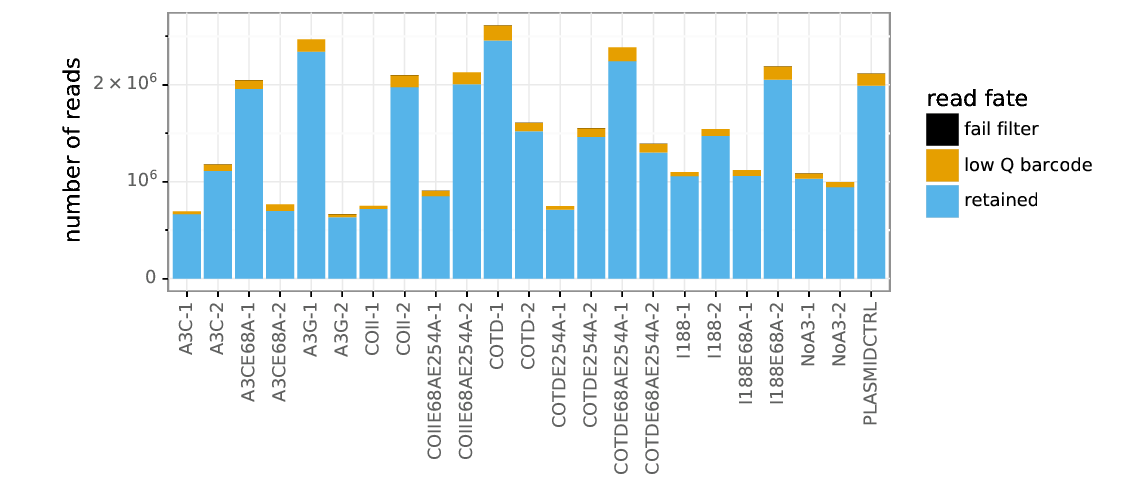

In [9]:
showPDF(countsplotprefix + '_readstats.pdf', width=600)

The `*_readsperbc.pdf` plot below shows how many times different barcodes were observed for each sample. Barcodes need to be observed multiple times to be useful for barcoded-subamplicon sequencing error correction.

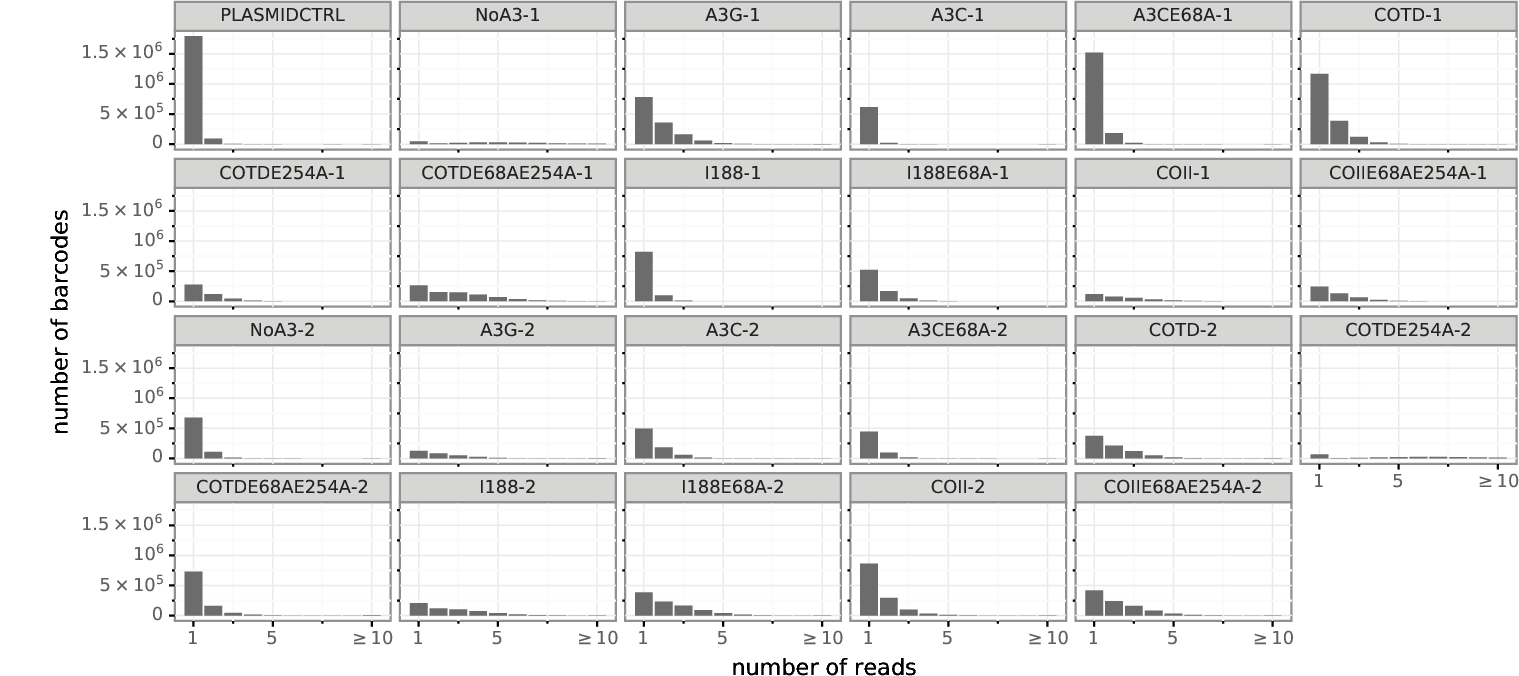

In [10]:
showPDF(countsplotprefix + '_readsperbc.pdf')

The `*_bcstats.pdf` plot below shows statistics on the barcodes. Some of the barcodes had to be discarded because they had too few reads (these are the single-read barcodes in the plot above), a small fraction with adequate reads were not alignable, and the rest aligned to the Env gene properly.
This plot and the one above suggest that probably could have gotten additional depth by sequencing more, since then we would have had more barcodes with multiple reads.

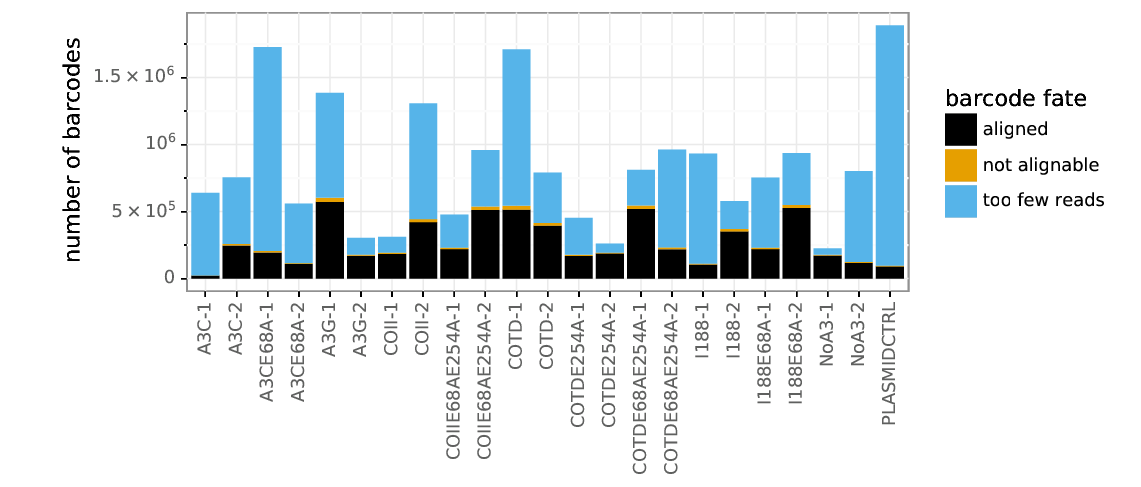

In [11]:
showPDF(countsplotprefix + '_bcstats.pdf', width=600)

The `*_depth.pdf` plot below shows the depth (number of called codons) at each site in the gene. 
For most of the samples, the depth across the gene is fairly uniform, indicating that the subamplicons were pooled fairly evenly.  
Note that some samples (in particular the mock samples) were intentionally sequenced to higher depth than the antibody-selected samples, as we expect to see more diversity in the mock samples. 
Note that the gene was not sequenced past codon site 691, and so there is no coverage there.

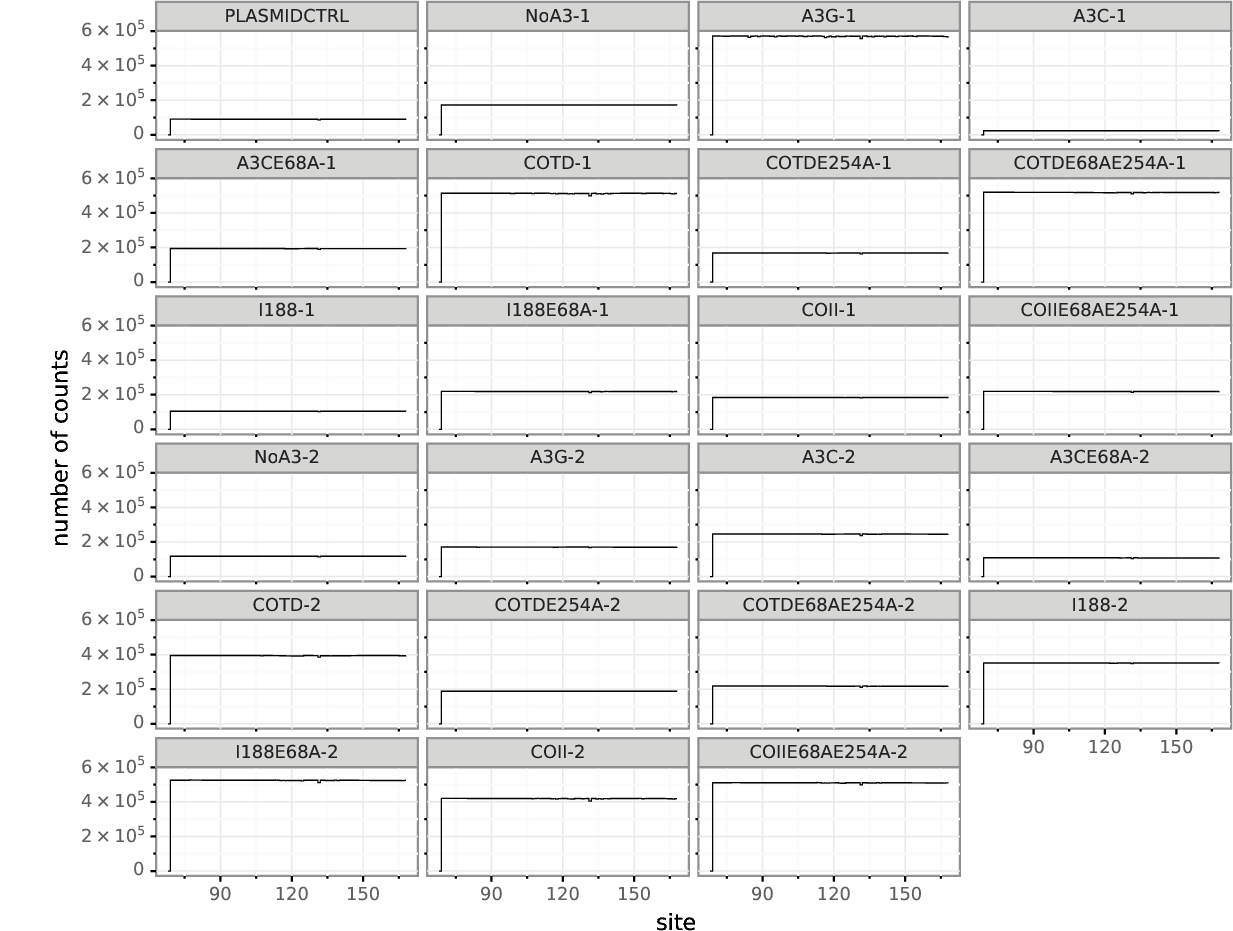

In [12]:
showPDF(countsplotprefix + '_depth.pdf')

The `*_mutfreq.pdf` plot below shows the per-codon frequency of mutations at each site. 
For each antibody-selected sample, we see a few sites of clear peaks in mutation frequency. 
These peaks tend to occur at the same sites in different replicates, and so presumably represent the sites where antibody-escape mutations are selected. 
There are no such peaks for the mock sample since there is no antibody selection to favor specific mutations.
Note also that the gene was not mutagenized or sequenced past codon site 691, so there are no mutations there.

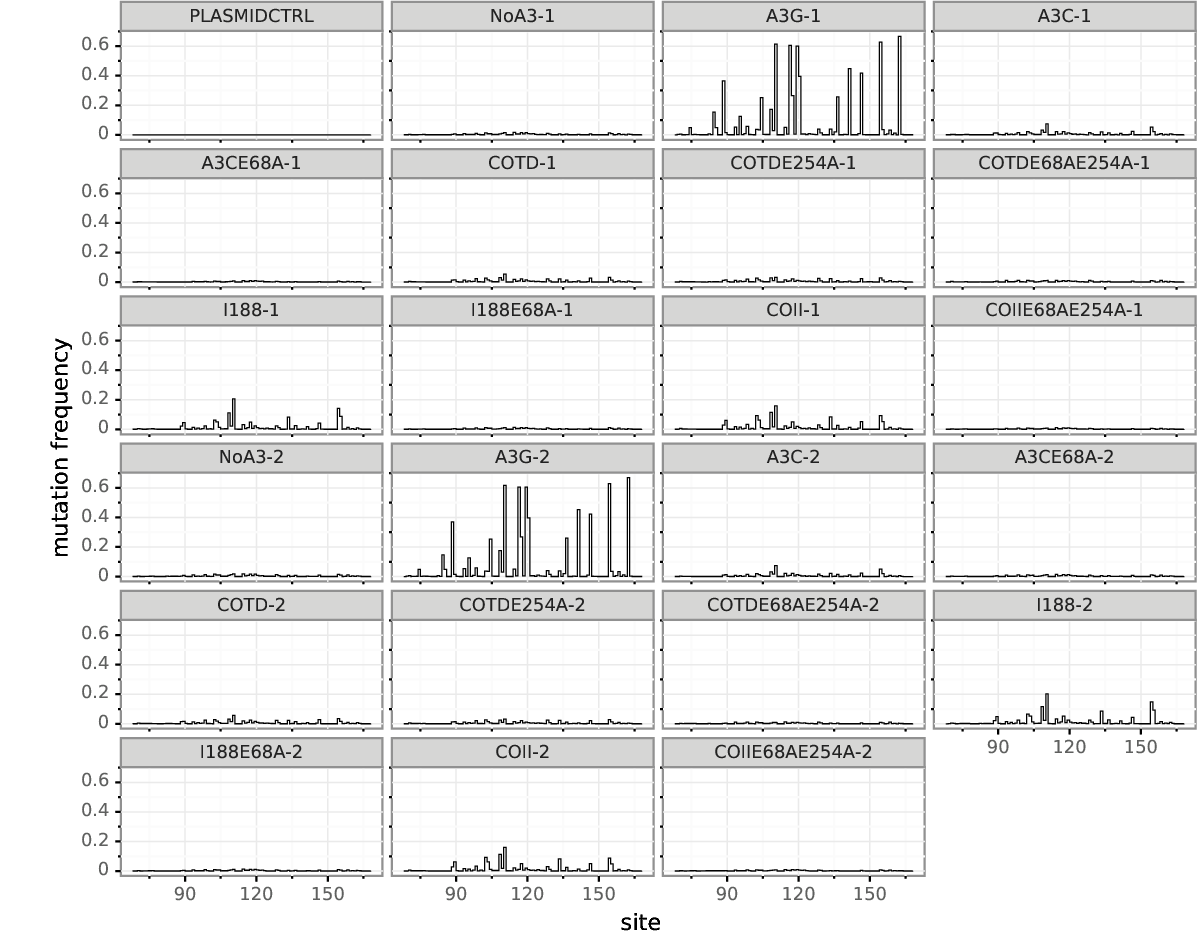

In [13]:
showPDF(countsplotprefix + '_mutfreq.pdf')

The `*_codonmuttypes.pdf` plot below shows the per-codon frequency of nonsynonymous, synonymous, and stop codon mutations across the entire gene. 

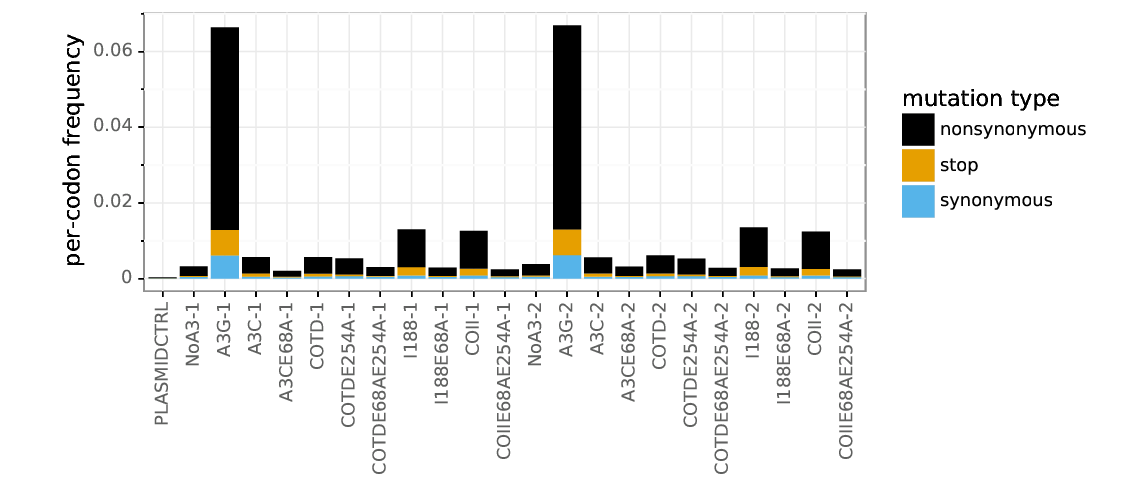

In [14]:
showPDF(countsplotprefix + '_codonmuttypes.pdf', width=600)

The `*_codonntchanges.pdf` plot below shows same data as above but categorizes codon mutations by the number of nucleotides that are changed (e.g., ATG to AAG changes 1 nucleotide, ATG to AAC changes 2 nucleotides, and ATG to CAC changes 3 nucleotides).

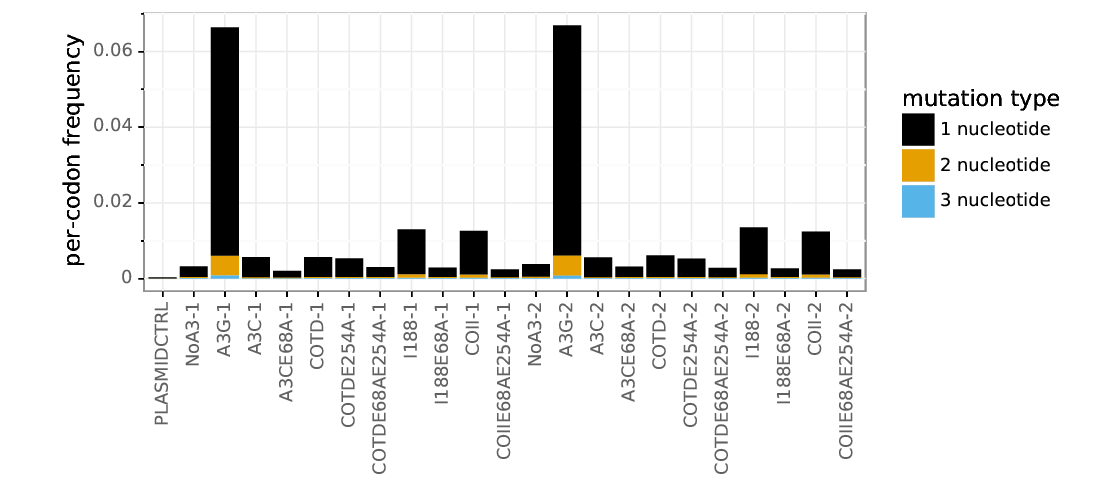

In [15]:
showPDF(countsplotprefix + '_codonntchanges.pdf', width=600)

The `*_singlentchanges.pdf` plot below shows the frequency of each type of nucleotide change among only codon mutations with one nucleotide change. This plot is mostly useful to check if there is a large bias in which mutations appear. In particular, if you are getting oxidative damage (which causes G to T mutations) during the library preparation process, you will see a large excess of C to A or G to T mutations (or both). There is not much oxidative damage in the samples plotted below, which mostly have a fairly even distribution of nucleotide changes.

We do see that transitions (G <-> A and C <-> T) are a bit more common than most of the other types of mutations (all of which are transversions). This is expected, since [PCR based sources of mutations are expected to preferentially introduce transitions](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3720931/). 

This plot would also be important to examine any sign of APOBEC hypermutation (also G <-> A, with preferences for specific motifs) occuring in the HIV genome. One of the reasons we selected the SupT1.R5 cell line was because [there is very little of the APOBEC proteins expressed in  a subclone of SupT1 cells](https://www.ncbi.nlm.nih.gov/pubmed/20308164). In the viral samples, there does appear to be an increase in G to A and C to T mutations. However, we passaged WT virus in these cells and confirmed there were not signs of extensive APOBEC hypermutation in hotspot motifs via deep sequencing of env after passaging. Thus, we do not think there is extensive APOBEC hypermutation in our data, and this increase certain types of mutations in the viral samples is likely due to bias in the viral reverse transcription.

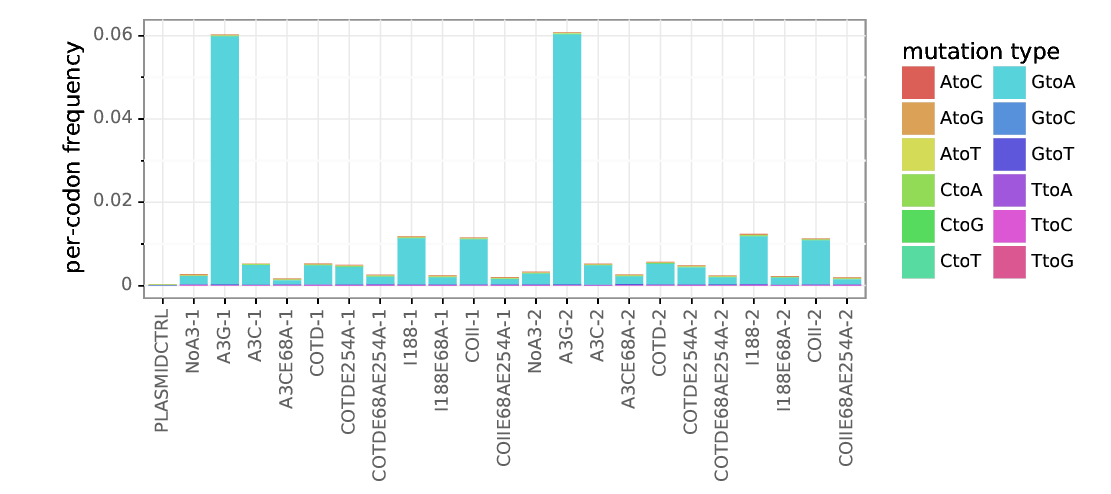

In [16]:
showPDF(countsplotprefix + '_singlentchanges.pdf', width=600)

# Analyze `bcinfo.csv.gz` output

The analysis immediately belwo uses the `.csv` output of the `bcinfo file` and makes a heatmap of mutation motifs. 

In [17]:
NTS = ('A', 'C', 'T', 'G', 'N')

def getSubstitutions_Nokay(mutant, wildtype):
    """Get space delimited string of substitutions

    Args:
        `wildtype` (str):
             The wildtype sequence
        `mutant` (str):
             The mutant sequence
    Returns:
        A space delimited string of substitutions present in the
        mutant sequence

    >>> getSubstitutions('AGT', 'TGT')
    'A1T'
    >>> getSubstitutions('AAGTAACGA', 'ATCTAACGA')
    'A2T G3C'
    """
    if mutant == 'None':
        return None
    elif len(wildtype) != len(mutant):
        print(wildtype)
        print(mutant)
        raise ValueError('wildtype and mutant must be same length')
    subs = []
    for site in range(len(wildtype)):
        wt = wildtype[site]
        mut = mutant[site]
        if mut == 'N':
            continue
        if wt not in NTS:
            raise ValueError (f"Invalid wt nucleotide {wt} at site {site+1}")
        if mut not in NTS:
            raise ValueError (f"Invalid mutant nucleotide {mut} at site {site+1}")
        if wt!=mut:
            pos = str(site + 1)
            subs.append(f"{wt}{pos}{mut}")
    subs = ' '.join(subs)

    return subs

In [18]:
NTS_noN = 'ACTG'
def motif_counts(seq):
    motif_counts = {}
    possible_motifs = itertools.product(NTS_noN, repeat=3)
    for motif in possible_motifs:
        motif = ('').join(motif)
        motif_counts[motif] = seq.count(motif)
    return(motif_counts)

In [19]:
trimmedrefseq = "CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAGGGGGGCAACTAAAGGAAGCTCTATTAGATACAGGAGCAGATGATACAGTATTAGAAGAAATGAGTTTGCCAGGAAGATGGAAACCAAAAATGATAGGGGGAATTGGAGGTTTTATCAAAGTAAGACAGTATGATCAGATACTCATAGAAATCTGTGGACATAAAGCTATAGGTACAGTATTAGTAGGACCTACACCTGTCAACATAATTGGAAGAAATCTGTTGACTCAGATTGGTTGCACTTTAAATTTTCCC"
refseq_motif_counts = motif_counts(trimmedrefseq)
baseline_motif_counts_df = pd.DataFrame.from_dict(refseq_motif_counts, orient='index', columns=['count']).sort_values('count')
baseline_motif_counts_df

,count
CGG,0
CGC,0
GCG,0
CCG,0
GTG,1
...,...
GAA,9
GAT,10
ATA,10
AAA,10


In [20]:
pseudocount = 1

bcinfo_dfs = {}
nts_retained = {}
df_samplenames = []
motif_counts_dict = {}
for sample in samplenames:
    df_samplename = sample.replace('_', '-')
    df_samplenames.append(df_samplename)
    
for sample in df_samplenames:
    print(sample)
    sample_mcounts = {}
    subs_list = []
    bcinfo_file = f"{countsdir}/{sample}_bcinfo.csv.gz"
    bcinfo_df = pd.read_csv(bcinfo_file)
    bcinfo_df_retained = bcinfo_df[bcinfo_df['Retained'] == True].reset_index(drop=True)
    bcinfo_df_retained['subs'] = bcinfo_df_retained['Consensus'].apply(getSubstitutions_Nokay, args=(trimmedrefseq,))

    for motif in refseq_motif_counts:
        sample_mcounts[motif] = len(bcinfo_df_retained) * refseq_motif_counts[motif] + pseudocount
    motif_counts_dict[sample] = sample_mcounts

    bcinfo_dfs[sample] = bcinfo_df_retained
    display(bcinfo_dfs[sample].head())
        

PLASMIDCTRL


,Barcode,Retained,Description,Consensus,R1_Count,R2_Count,subs
0,CAAGATCGATTAAGCT,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,2,2,
1,ACAGATCATGTGTATG,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,2,2,
2,ATATCGACGAGTTCCC,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,2,2,
3,GATGTCTCTAGGGGAC,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,2,2,
4,GGCGCGTCAGTCCAGA,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,2,2,


NoA3-1


,Barcode,Retained,Description,Consensus,R1_Count,R2_Count,subs
0,CACAAACGTAAGCGGG,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,3,3,
1,TCCCTCCACGAGATAC,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,9,9,
2,ATCGGGGGCCTTGCTA,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,7,7,G61A G108A
3,AATGCTATACCAGAAA,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,8,8,
4,CCAACGGTCCGCATTC,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,6,6,


A3G-1


,Barcode,Retained,Description,Consensus,R1_Count,R2_Count,subs
0,ACCGCCAGGGGGAATG,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,3,3,G61A G118A G125A G142A G144A G145A G151A G154A...
1,ACTTCGCTATATCGTG,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,4,4,
2,GGAAGTGGAAGGCATC,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,4,4,
3,ATCGGGAAACAATGTA,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,3,3,
4,AGCTGATTAGAAATCA,True,aligned at position 205,CCTCAGATCACTCTTTAGCAACGACCCCTCGTCACAATAAAAATAA...,4,4,G17A G42A G46A G47A G48A G49A G61A G73A G79A G...


A3C-1


,Barcode,Retained,Description,Consensus,R1_Count,R2_Count,subs
0,CGAAACCCGAATCGGG,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,2,2,
1,CGCGAATGCGGCATGC,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,2,2,
2,TGAGGCTGGCAAATTA,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,2,2,
3,GTGGTGCGGAGAACCC,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATNNAGATAG...,2,2,G103A G126A
4,ATTTGCCTCTTGGTGA,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,2,2,


A3CE68A-1


,Barcode,Retained,Description,Consensus,R1_Count,R2_Count,subs
0,ATGACTACGTTTAGTA,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,2,2,
1,AGTTCCTTCACCGGTA,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,2,2,
2,ATGGAGTTGATTGCAG,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,2,2,
3,AAGGGCAAGATTGTTT,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,2,2,
4,CACTCAATTTTGTTAC,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,2,2,


COTD-1


,Barcode,Retained,Description,Consensus,R1_Count,R2_Count,subs
0,CGAAATCGGCCTTCAG,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,2,2,
1,GCTAGCAATAAGACAT,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,3,3,G88A G178A G260A
2,CAAACAAGAAGGTCGA,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,3,3,
3,ATAACCGGGCATGGGA,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,2,2,
4,AGTGAAGCTGTACGTC,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,3,3,


COTDE254A-1


,Barcode,Retained,Description,Consensus,R1_Count,R2_Count,subs
0,CGGTTCAAGCCGATGG,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,4,4,
1,ACGCTTCGGTCATTGA,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,2,2,
2,CAGCGCAGCGAGCATA,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,2,2,
3,GAAAAACTGACGGATA,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,4,4,
4,CCTGTGTAGTACGGTG,True,aligned at position 205,CCTCAGATCACTCTTTGGTAACGACCCCTCGTCACAATAAAGATAG...,2,2,C19T


COTDE68AE254A-1


,Barcode,Retained,Description,Consensus,R1_Count,R2_Count,subs
0,AAGGAGTAAACAGAGT,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,4,4,
1,TCACTGTCGAGGTCGC,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,5,5,G138T
2,AGAAGTCTCAGACCTA,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,3,3,
3,GCAGAGTGGGAGTCTA,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,3,3,
4,TAATAAAAAGGGATGT,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,4,4,


I188-1


,Barcode,Retained,Description,Consensus,R1_Count,R2_Count,subs
0,AAGCACAGTGGCGCAC,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,2,2,G119A G125A G257A G260A
1,CATATCTGTACGGAGC,True,aligned at position 205,CCTCTGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,2,2,A5T
2,TGGTTGAAGTGCCCTC,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,2,2,
3,AGAGTAAAGGGTTCCA,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,2,2,
4,TCAACCTGTGCCGGTA,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,2,2,G256A


I188E68A-1


,Barcode,Retained,Description,Consensus,R1_Count,R2_Count,subs
0,GCTAGGAGACCTAAAA,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,2,2,
1,GTGGAGAAAAGTTGGC,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,2,2,
2,GGGCTAGAATCCTTAA,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,3,3,
3,TAGTTGTGAATGATGG,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,3,3,
4,GAAAACGAGGGTACGA,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,2,2,


COII-1


,Barcode,Retained,Description,Consensus,R1_Count,R2_Count,subs
0,GAGCGGTCGATCAGAA,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,6,6,
1,CACAGAAAGCAAAAGT,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,7,7,
2,CTGATGAGCGTATTAA,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,4,4,
3,GCACCATGGGTATAGC,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,2,2,G100A G178A G193A G256A
4,ATCGTGGTGCGCATTA,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,5,5,G61A G100A G103A G108A G125A G126A G155A G193A...


COIIE68AE254A-1


,Barcode,Retained,Description,Consensus,R1_Count,R2_Count,subs
0,CATTTATTTATCGTGG,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,4,4,
1,GGGTAGTAGATGACGC,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,4,4,
2,AGCACGTGTAAGGTAA,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,2,2,
3,GAACCGCTCCTGGACC,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,5,5,
4,CGGGCGGGAGTGGGGT,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,2,2,


NoA3-2


,Barcode,Retained,Description,Consensus,R1_Count,R2_Count,subs
0,GCACCCGGAACAGGCT,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,2,2,
1,TAAACAAATCCAGCAG,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,2,2,
2,AGTCCAGGGTATTGCC,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,2,2,
3,AAATACGCAAGAACCT,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,2,2,G61A G73A G88A G138A G151A G233A G260A G270A G...
4,CACTTAGCGGCCTAAA,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,3,3,


A3G-2


,Barcode,Retained,Description,Consensus,R1_Count,R2_Count,subs
0,GGCTCTACCGCCTGAC,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,2,2,G60A G119A G125A G142A G144A G232A G256A G280A
1,CTAACAAGCGTTAGAA,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAA...,2,2,G46A G49A G60A G125A G142A G144A G145A G151A G...
2,TACGTGACCACTAAAA,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,2,2,G100A G144A G151A
3,ACCAGCGGCGTGCTTT,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,2,2,
4,AGCCAATTGTGTGATT,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAA...,4,4,G46A G73A G125A G126A G142A G143A G144A G145A ...


A3C-2


,Barcode,Retained,Description,Consensus,R1_Count,R2_Count,subs
0,AAAGAGATCGCGCAGA,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,2,2,
1,GCCAATCGAGCAGAGT,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,2,2,
2,GCTGTGGCGAAATCAT,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,3,3,
3,TAGGTAAGCAGTGTAG,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,2,2,
4,AGGGTCACATATCAAA,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,3,3,


A3CE68A-2


,Barcode,Retained,Description,Consensus,R1_Count,R2_Count,subs
0,TGGAACGCTCACGACG,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,3,3,
1,GGTGTAGCGGATTGGG,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCNCTCGTCACAATAAAGATAG...,3,3,
2,AGTAGTAGGCATCGAT,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,2,2,
3,AGGGAACAGATCCATG,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,3,3,G100A
4,GCCCTTAGGCGGAGAT,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,2,2,


COTD-2


,Barcode,Retained,Description,Consensus,R1_Count,R2_Count,subs
0,GCTGGAACCATTCACA,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,2,2,
1,ATACACACTCTCATAC,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,4,4,G119A
2,TGCAAAATTGCGTATC,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,2,2,
3,GAAACCAGTGGCGTTA,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,2,2,
4,AAAGCACGGGTGCGAA,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,2,2,


COTDE254A-2


,Barcode,Retained,Description,Consensus,R1_Count,R2_Count,subs
0,GCGTATGGGCGCTGTA,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,7,7,
1,ATCGATTTCGCCTGGT,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,8,8,G218A
2,CAAATGACTTGAAAGT,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,8,8,G108T
3,AAGTTCGGCTACCCTA,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,13,13,
4,TGAAAACGGTGCGGTG,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,5,5,


COTDE68AE254A-2


,Barcode,Retained,Description,Consensus,R1_Count,R2_Count,subs
0,CAGGGTGGGATATTTA,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,4,4,
1,GACGTGCTCGTACCAT,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,3,3,
2,GAGCCTCGGTTCGGTG,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,2,2,A153T
3,AAAGCTAGTGACGTTC,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,2,2,
4,ACTGTGGCGAATATTA,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,3,3,G122A


I188-2


,Barcode,Retained,Description,Consensus,R1_Count,R2_Count,subs
0,ATATAGCCCAGTTGGT,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,4,4,A136T T137G G138A A139T T140A A141G G146A A148...
1,AGAAAGACCGACGCGG,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,3,3,
2,TGGCAAATGTAGGATA,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,3,3,
3,GTAAGTAAATATACAC,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,3,3,
4,AGGTCCTGGTTCAAAC,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,4,4,G60A G119A G125A G166A G193A G257A


I188E68A-2


,Barcode,Retained,Description,Consensus,R1_Count,R2_Count,subs
0,GACCAATTATAGGCTG,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,4,4,
1,TGGGGCACCGTTCATA,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,2,2,
2,AAGAAGCACTCTTTGG,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,6,6,
3,GCCAAGGTAAGTACTG,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,3,3,A136T T137G G138A A139T T140A A141G G146A A148...
4,AGCAACACAGTAACGG,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,2,2,


COII-2


,Barcode,Retained,Description,Consensus,R1_Count,R2_Count,subs
0,ACCATATACTTGCTGT,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,2,2,
1,GCAACGGGTCAAGGCA,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,7,7,G202A G256A
2,TGGTATCCGGTGGCCG,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,3,3,
3,AGTGTACCTAAGGCTG,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,5,5,
4,CTAGCGGCATGCGCCC,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,2,2,G126A G138A G223A


COIIE68AE254A-2


,Barcode,Retained,Description,Consensus,R1_Count,R2_Count,subs
0,CTAAGTCCTATACGTG,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,6,6,
1,GCAAGGAAAAGGATCG,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,2,2,
2,AGCGCATGGTAACTCA,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,2,2,
3,TACTTCGTGTCAGAGT,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCGCAATAAAGATAG...,2,2,A34G
4,ACTTTAACAGAACGAT,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,4,4,


In [21]:
def subs_to_motifs(subs_list, gene):
    """Return substitution as tuple (5'nt, sub, 3'nt)."""
    motifs = []
    for sub in subs_list:
        site = int(sub[1:-1])
        change = f"{sub[0]}{sub[-1]}"
        if site == 1:
            threeprime_nt = gene[site]
            motif = (None, change, threeprime_nt, None)
        elif site == len(gene):
            fiveprime_nt = gene[site-2]
            motif = (fiveprime_nt, change, None, None)
        else:
            fiveprime_nt = gene[site-2]
            threeprime_nt = gene[site]
            threent_motif = gene[site-2:site+1]
            motif = (fiveprime_nt, change, threeprime_nt, threent_motif)
        motifs.append(motif)
    return(motifs)

In [22]:
mutinfo_dfs = {}
for sample in df_samplenames:
    print(sample)
    sample_mut_motifs = []
    sample_num_muts = []
    bcinfo_df = bcinfo_dfs[sample]
    sample_reads = len(bcinfo_df)
    bcs_with_subs = bcinfo_df[bcinfo_df['subs'] != ''].reset_index(drop=True)
    sample_sub_reads = len(bcs_with_subs)
    # 'N's not counted as subs
    print(f"{sample_sub_reads} out of {sample_reads} barcodes ({round(sample_sub_reads/sample_reads*100, 2)}%) for {sample} have substitutions")
    for i in range(len(bcs_with_subs)):
        subs_list = bcs_with_subs.iloc[i]['subs'].split(' ')
        num_muts = len(subs_list)
        mut_motifs = subs_to_motifs(subs_list, trimmedrefseq)
        sample_mut_motifs.append([mut_motifs])
        sample_num_muts.append(num_muts)
    sample_mutinfo_df = bcs_with_subs.join(pd.DataFrame(sample_mut_motifs, columns=['sub_tups']))
    sample_mutinfo_df['n_subs'] = sample_num_muts
    mutinfo_dfs[sample] = sample_mutinfo_df
    display(mutinfo_dfs[sample].tail(3))

PLASMIDCTRL
2177 out of 90920 barcodes (2.39%) for PLASMIDCTRL have substitutions


,Barcode,Retained,Description,Consensus,R1_Count,R2_Count,subs,sub_tups,n_subs
2174,AAAGAGAGGGAGCCGA,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,2,2,C198A,"[(T, CA, T, TCT)]",1
2175,GTGTGCACTCTGCTGA,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,2,2,G142T,"[(A, GT, G, AGG)]",1
2176,AATAGGTGCCGGGAGT,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,2,2,C116A,"[(C, CA, A, CCA)]",1


NoA3-1
24112 out of 172603 barcodes (13.97%) for NoA3-1 have substitutions


,Barcode,Retained,Description,Consensus,R1_Count,R2_Count,subs,sub_tups,n_subs
24109,GGCAGGTTAGCGTGTT,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,2,2,G100A,"[(A, GA, A, AGA)]",1
24110,GGAGGCGGGACCGACG,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,2,2,G244A,"[(T, GA, T, TGT)]",1
24111,CAATATCTCGATGAGA,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,2,2,A147G T149A G151T A153G G154A T156G A160T T161...,"[(G, AG, A, GAA), (A, TA, T, ATT), (T, GT, G, ...",10


A3G-1
508627 out of 572883 barcodes (88.78%) for A3G-1 have substitutions


,Barcode,Retained,Description,Consensus,R1_Count,R2_Count,subs,sub_tups,n_subs
508624,AATAAGAGGGCGGGAA,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,2,2,G217A G256A G280A,"[(A, GA, G, AGG), (T, GA, G, TGG), (T, GA, G, ...",3
508625,TCTAAGTGTGTCTAAA,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,2,2,G143A G256A G280A,"[(G, GA, G, GGG), (T, GA, G, TGG), (T, GA, G, ...",3
508626,ATTCGAAGAGTATACG,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,2,2,G48A G73A G88A G122A G126A G138A G146A G178A G...,"[(G, GA, G, GGG), (A, GA, A, AGA), (T, GA, A, ...",11


A3C-1
7418 out of 23214 barcodes (31.95%) for A3C-1 have substitutions


,Barcode,Retained,Description,Consensus,R1_Count,R2_Count,subs,sub_tups,n_subs
7415,GCGGGACTACACGATT,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,2,2,G223A,"[(A, GA, T, AGT)]",1
7416,TAGAATGGCTAATCAG,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAANGATAG...,2,2,G151A,"[(T, GA, G, TGG)]",1
7417,TCAGCTAGAGAAATTG,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,2,2,G88A G100A,"[(T, GA, A, TGA), (A, GA, A, AGA)]",2


A3CE68A-1
21370 out of 194728 barcodes (10.97%) for A3CE68A-1 have substitutions


,Barcode,Retained,Description,Consensus,R1_Count,R2_Count,subs,sub_tups,n_subs
21367,AGCAGGAGGGTATAAA,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,2,2,G276A,"[(A, GA, A, AGA)]",1
21368,ATGGTGTTGACACGAG,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,2,2,G138A G154T G193A G260A,"[(T, GA, A, TGA), (A, GT, G, AGG), (A, GA, A, ...",4
21369,GATGTAGGCGAAAGAG,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,2,2,C189T,"[(T, CT, A, TCA)]",1


COTD-1
157751 out of 515135 barcodes (30.62%) for COTD-1 have substitutions


,Barcode,Retained,Description,Consensus,R1_Count,R2_Count,subs,sub_tups,n_subs
157748,ATAGGGTGGGGTGTGG,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,2,2,G193A,"[(A, GA, A, AGA)]",1
157749,AAAAAGACCGCACATA,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,2,2,G138A,"[(T, GA, A, TGA)]",1
157750,GTTACGTAGGATCGTT,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,2,2,G125A G257A,"[(T, GA, G, TGG), (G, GA, A, GGA)]",2


COTDE254A-1
49953 out of 168837 barcodes (29.59%) for COTDE254A-1 have substitutions


,Barcode,Retained,Description,Consensus,R1_Count,R2_Count,subs,sub_tups,n_subs
49950,AAGATAGTCGGTCCTT,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,2,2,G280A,"[(T, GA, G, TGG)]",1
49951,GCACAAACGTCTCCGT,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,2,2,G122A,"[(A, GA, A, AGA)]",1
49952,ACACAAGGCGGCACCG,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,2,2,G166A G174A G178A G183A,"[(A, GA, T, AGT), (A, GA, T, AGT), (T, GA, A, ...",4


COTDE68AE254A-1
60976 out of 519559 barcodes (11.74%) for COTDE68AE254A-1 have substitutions


,Barcode,Retained,Description,Consensus,R1_Count,R2_Count,subs,sub_tups,n_subs
60973,AAATGATAAACCGTGT,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,2,2,G88A G119A G257A G270A,"[(T, GA, A, TGA), (G, GA, A, GGA), (G, GA, A, ...",4
60974,GAGGCGGGACCTTTTG,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,2,2,A109G,"[(G, AG, G, GAG)]",1
60975,AGCCGGGAGAGAGATA,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,2,2,C115T,"[(G, CT, C, GCC)]",1


I188-1
55372 out of 105072 barcodes (52.7%) for I188-1 have substitutions


,Barcode,Retained,Description,Consensus,R1_Count,R2_Count,subs,sub_tups,n_subs
55369,AATCCTAAGTAAGGCA,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,2,2,G256A,"[(T, GA, G, TGG)]",1
55370,AGCTACGATGTATTAA,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,2,2,G61A G126A,"[(G, GA, A, GGA), (G, GA, A, GGA)]",2
55371,AGATGCTATGAGCAGT,True,aligned at position 205,CCTCAGATCACTCTCTGGCAACGACCCCTCGTCACAATAAAGATAG...,2,2,T15C,"[(T, TC, T, TTT)]",1


I188E68A-1
26575 out of 219921 barcodes (12.08%) for I188E68A-1 have substitutions


,Barcode,Retained,Description,Consensus,R1_Count,R2_Count,subs,sub_tups,n_subs
26572,GGTGGGACGTTCGCTT,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,2,2,G100A,"[(A, GA, A, AGA)]",1
26573,CACGCTCACATGACAT,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,2,2,G100A,"[(A, GA, A, AGA)]",1
26574,TCTATCACTAAACATC,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,2,2,G80A G125A,"[(G, GA, A, GGA), (T, GA, G, TGG)]",2


COII-1
90280 out of 184551 barcodes (48.92%) for COII-1 have substitutions


,Barcode,Retained,Description,Consensus,R1_Count,R2_Count,subs,sub_tups,n_subs
90277,GAACGAAAGGGGGATT,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,2,2,T87A G100A G178A G257A,"[(A, TA, G, ATG), (A, GA, A, AGA), (T, GA, A, ...",4
90278,GGAAAAGGCGCCACTG,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,2,2,G61A G126A G256A,"[(G, GA, A, GGA), (G, GA, A, GGA), (T, GA, G, ...",3
90279,AGCTGAGGCAACGTAA,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,2,2,G61A G103A,"[(G, GA, A, GGA), (A, GA, A, AGA)]",2


COIIE68AE254A-1
25087 out of 219978 barcodes (11.4%) for COIIE68AE254A-1 have substitutions


,Barcode,Retained,Description,Consensus,R1_Count,R2_Count,subs,sub_tups,n_subs
25084,GACGCAAGGTTACGTA,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,2,2,G138A,"[(T, GA, A, TGA)]",1
25085,AACGTTAAAAATGGCA,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,2,2,T107A,"[(A, TA, G, ATG)]",1
25086,GATGTGGTCTATCACG,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,2,2,G82A,"[(A, GA, C, AGC)]",1


NoA3-2
16930 out of 117643 barcodes (14.39%) for NoA3-2 have substitutions


,Barcode,Retained,Description,Consensus,R1_Count,R2_Count,subs,sub_tups,n_subs
16927,AGGGGAGCCCACCTCT,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,2,2,G276A,"[(A, GA, A, AGA)]",1
16928,TATCCGGGAAACAAGC,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,2,2,G85A G193A,"[(A, GA, A, AGA), (A, GA, A, AGA)]",2
16929,GTAGCAAACGTTATGG,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,2,2,C285T,"[(G, CT, A, GCA)]",1


A3G-2
151761 out of 170836 barcodes (88.83%) for A3G-2 have substitutions


,Barcode,Retained,Description,Consensus,R1_Count,R2_Count,subs,sub_tups,n_subs
151758,CTACTTCTCATCCATA,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,2,2,G125A G142A G144A G151A G211A G217A G232A G256...,"[(T, GA, G, TGG), (A, GA, G, AGG), (G, GA, G, ...",9
151759,ACTACCGGGGGGGCCG,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,2,2,G125A G142A G144A G151A G154A G232A G256A G280A,"[(T, GA, G, TGG), (A, GA, G, AGG), (G, GA, G, ...",8
151760,CTCGGTATGGCAGGTC,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,2,2,G151A G217A G280A,"[(T, GA, G, TGG), (A, GA, G, AGG), (T, GA, G, ...",3


A3C-2
77474 out of 246836 barcodes (31.39%) for A3C-2 have substitutions


,Barcode,Retained,Description,Consensus,R1_Count,R2_Count,subs,sub_tups,n_subs
77471,GAACTGGGTTGAGGTC,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,2,2,G183A,"[(A, GA, A, AGA)]",1
77472,CATGGACCGGGGGAAC,True,aligned at position 205,CNTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,2,2,G50A,"[(G, GA, G, GGG)]",1
77473,TCGCGAAGTACGAGAG,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,2,2,G60A,"[(A, GA, G, AGG)]",1


A3CE68A-2
13867 out of 109300 barcodes (12.69%) for A3CE68A-2 have substitutions


,Barcode,Retained,Description,Consensus,R1_Count,R2_Count,subs,sub_tups,n_subs
13864,GACCGGTCGCGGTACG,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,2,2,G61A G100A,"[(G, GA, A, GGA), (A, GA, A, AGA)]",2
13865,GACGATCGTGGTAGAG,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,2,2,G183T,"[(A, GT, A, AGA)]",1
13866,TTGGTATAGACATACT,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,2,2,G146A,"[(G, GA, A, GGA)]",1


COTD-2
124446 out of 395608 barcodes (31.46%) for COTD-2 have substitutions


,Barcode,Retained,Description,Consensus,R1_Count,R2_Count,subs,sub_tups,n_subs
124443,TTCAAGTAGTTAGTTT,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGACAG...,2,2,T44C G88A G126A,"[(A, TC, A, ATA), (T, GA, A, TGA), (G, GA, A, ...",3
124444,TCGGCGGGGGAGGTGG,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,2,2,G232A,"[(A, GA, G, AGG)]",1
124445,GACTGCAGGTAGAGGG,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,2,2,G61A,"[(G, GA, A, GGA)]",1


COTDE254A-2
55947 out of 188193 barcodes (29.73%) for COTDE254A-2 have substitutions


,Barcode,Retained,Description,Consensus,R1_Count,R2_Count,subs,sub_tups,n_subs
55944,TGGTATATGGTGATCT,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,2,2,G103A T107A G108T A109G G110A T111G G114T C115...,"[(A, GA, A, AGA), (A, TA, G, ATG), (T, GT, A, ...",34
55945,GCTGAAGATCAAGGCT,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,2,2,C181A,"[(T, CA, A, TCA)]",1
55946,TGACCATTGATTAACA,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,2,2,G61A,"[(G, GA, A, GGA)]",1


COTDE68AE254A-2
24033 out of 218925 barcodes (10.98%) for COTDE68AE254A-2 have substitutions


,Barcode,Retained,Description,Consensus,R1_Count,R2_Count,subs,sub_tups,n_subs
24030,TCATATGGTGAAGTAT,True,aligned at position 205,CCTAAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,2,2,C4A,"[(T, CA, A, TCA)]",1
24031,AGGGACCGATATAGGG,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,2,2,G73A G88A G100A G103A G108A G138A G152A G178A ...,"[(A, GA, A, AGA), (T, GA, A, TGA), (A, GA, A, ...",11
24032,CAGGCCGACCGGAAAG,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,2,2,G146T,"[(G, GT, A, GGA)]",1


I188-2
188994 out of 352649 barcodes (53.59%) for I188-2 have substitutions


,Barcode,Retained,Description,Consensus,R1_Count,R2_Count,subs,sub_tups,n_subs
188991,GCTTAGTCGTAGGTAG,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,2,2,G119A G126A G233A,"[(G, GA, A, GGA), (G, GA, A, GGA), (G, GA, A, ...",3
188992,ACTAGGGTGTAGCGAT,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,2,2,A136T T137G G138A A139T T140A A141G G146A A148...,"[(A, AT, T, AAT), (A, TG, G, ATG), (T, GA, A, ...",16
188993,TAGGGTATTGTTTGAC,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,2,2,G119A G125A G126A G257A G260A,"[(G, GA, A, GGA), (T, GA, G, TGG), (G, GA, A, ...",5


I188E68A-2
58368 out of 526606 barcodes (11.08%) for I188E68A-2 have substitutions


,Barcode,Retained,Description,Consensus,R1_Count,R2_Count,subs,sub_tups,n_subs
58365,TAAGTGACTGTGGGAT,True,aligned at position 205,CCTCAGATCACTCTTTGGCAATGACCCCTCGTCACAATAAAGATAG...,2,2,C22T,"[(A, CT, G, ACG)]",1
58366,GAAGATGCGGATCGGG,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,2,2,C236A,"[(C, CA, T, CCT)]",1
58367,AATCGTTGTGGAAAAA,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,2,2,A153G,"[(G, AG, G, GAG)]",1


COII-2
206036 out of 421131 barcodes (48.92%) for COII-2 have substitutions


,Barcode,Retained,Description,Consensus,R1_Count,R2_Count,subs,sub_tups,n_subs
206033,TGTTCAGCCAGACGCG,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,2,2,G103A G257A G280A,"[(A, GA, A, AGA), (G, GA, A, GGA), (T, GA, G, ...",3
206034,CATCGAAGGAACGGCA,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,2,2,G100A G119A G125A G232A,"[(A, GA, A, AGA), (G, GA, A, GGA), (T, GA, G, ...",4
206035,TCTAAGAAGCCAAAAG,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,2,2,G61A G73A G82A G100A G103A G125A G126A G256A G...,"[(G, GA, A, GGA), (A, GA, A, AGA), (A, GA, C, ...",9


COIIE68AE254A-2
57163 out of 512158 barcodes (11.16%) for COIIE68AE254A-2 have substitutions


,Barcode,Retained,Description,Consensus,R1_Count,R2_Count,subs,sub_tups,n_subs
57160,TTGGCTGCGAGACGAC,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,2,2,G138A,"[(T, GA, A, TGA)]",1
57161,TAATGCCCGAGCAAGT,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,2,2,G126A,"[(G, GA, A, GGA)]",1
57162,GTATACCAAATGGTTT,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAAATAG...,2,2,G42A,"[(A, GA, A, AGA)]",1


PLASMIDCTRL


,3',5',count,freq,motif,sub,sub_cat
50,C,G,44,0.000484,GCC,CT,one
82,A,T,161,0.000354,TGA,GT,one
35,A,T,191,0.000263,TCA,CA,one
36,C,T,23,0.000253,TCC,CA,one
49,A,G,87,0.000239,GCA,CT,one


NoA3-1


,3',5',count,freq,motif,sub,sub_cat
398,A,T,5565,0.006448,TGA,GA,high
394,A,G,6426,0.004137,GGA,GA,high
389,A,A,6216,0.003001,AGA,GA,high
400,G,T,2173,0.002098,TGG,GA,high
250,A,T,1796,0.002081,TGA,GA,low


A3G-1


,3',5',count,freq,motif,sub,sub_cat
245,G,T,902904,0.262678,TGG,GA,low
417,G,G,345671,0.201129,GGG,GA,high
421,G,T,664228,0.193241,TGG,GA,high
241,G,G,285767,0.166274,GGG,GA,low
411,G,A,691721,0.150930,AGG,GA,high


A3C-1


,3',5',count,freq,motif,sub,sub_cat
195,G,T,1139,0.008177,TGG,GA,low
189,A,G,1505,0.007203,GGA,GA,low
73,G,T,842,0.006045,TGG,GA,one
193,A,T,638,0.005497,TGA,GA,low
67,A,G,1070,0.005121,GGA,GA,one


A3CE68A-1


,3',5',count,freq,motif,sub,sub_cat
413,A,T,2640,0.002711,TGA,GA,high
409,A,G,3255,0.001857,GGA,GA,high
259,A,T,1286,0.001321,TGA,GA,low
349,G,G,764,0.001308,GAG,AG,high
437,T,G,649,0.001111,GGT,GT,high


COTD-1


,3',5',count,freq,motif,sub,sub_cat
271,A,T,18884,0.007332,TGA,GA,low
267,A,G,30118,0.006496,GGA,GA,low
273,G,T,19694,0.006372,TGG,GA,low
261,A,A,32589,0.005272,AGA,GA,low
102,G,T,13104,0.004240,TGG,GA,one


COTDE254A-1


,3',5',count,freq,motif,sub,sub_cat
248,A,T,5757,0.006820,TGA,GA,low
244,A,G,7725,0.005084,GGA,GA,low
238,A,A,9939,0.004906,AGA,GA,low
250,G,T,4345,0.004289,TGG,GA,low
90,A,T,3235,0.003832,TGA,GA,one


COTDE68AE254A-1


,3',5',count,freq,motif,sub,sub_cat
389,A,T,16449,0.006332,TGA,GA,high
385,A,G,17662,0.003777,GGA,GA,high
380,A,A,20818,0.003339,AGA,GA,high
243,A,T,8247,0.003175,TGA,GA,low
391,G,T,5195,0.001666,TGG,GA,high


I188-1


,3',5',count,freq,motif,sub,sub_cat
243,A,G,34790,0.036790,GGA,GA,low
249,G,T,14579,0.023125,TGG,GA,low
237,A,A,24294,0.019268,AGA,GA,low
247,A,T,5336,0.010157,TGA,GA,low
85,A,G,8625,0.009121,GGA,GA,one


I188E68A-1


,3',5',count,freq,motif,sub,sub_cat
415,A,T,6861,0.006240,TGA,GA,high
411,A,G,7894,0.003988,GGA,GA,high
405,A,A,8076,0.003060,AGA,GA,high
417,G,T,2674,0.002026,TGG,GA,high
255,A,T,1938,0.001762,TGA,GA,low


COII-1


,3',5',count,freq,motif,sub,sub_cat
228,A,G,56669,0.034118,GGA,GA,low
222,A,A,47719,0.021547,AGA,GA,low
234,G,T,20648,0.018647,TGG,GA,low
232,A,T,12327,0.013359,TGA,GA,low
224,G,A,14979,0.010146,AGG,GA,low


COIIE68AE254A-1


,3',5',count,freq,motif,sub,sub_cat
408,A,T,4828,0.004390,TGA,GA,high
404,A,G,5451,0.002753,GGA,GA,high
398,A,A,5475,0.002074,AGA,GA,high
254,A,T,1712,0.001557,TGA,GA,low
345,G,G,960,0.001455,GAG,AG,high


NoA3-2


,3',5',count,freq,motif,sub,sub_cat
399,A,T,5498,0.009347,TGA,GA,high
395,A,G,6325,0.005974,GGA,GA,high
390,A,A,6539,0.004632,AGA,GA,high
401,G,T,2392,0.003389,TGG,GA,high
245,A,T,1295,0.002202,TGA,GA,low


A3G-2


,3',5',count,freq,motif,sub,sub_cat
219,G,T,269894,0.263307,TGG,GA,low
383,G,G,103209,0.201380,GGG,GA,high
387,G,T,199980,0.195099,TGG,GA,high
215,G,G,84552,0.164977,GGG,GA,low
377,G,A,208945,0.152884,AGG,GA,high


A3C-2


,3',5',count,freq,motif,sub,sub_cat
262,G,T,12245,0.008268,TGG,GA,low
256,A,G,16535,0.007443,GGA,GA,low
260,A,T,7379,0.005979,TGA,GA,low
97,G,T,8593,0.005802,TGG,GA,one
91,A,G,11162,0.005024,GGA,GA,one


A3CE68A-2


,3',5',count,freq,motif,sub,sub_cat
384,A,T,3894,0.007125,TGA,GA,high
380,A,G,4421,0.004494,GGA,GA,high
375,A,A,4547,0.003467,AGA,GA,high
386,G,T,1567,0.002389,TGG,GA,high
238,A,T,971,0.001777,TGA,GA,low


COTD-2


,3',5',count,freq,motif,sub,sub_cat
269,A,T,15645,0.007909,TGA,GA,low
265,A,G,25120,0.007055,GGA,GA,low
271,G,T,16111,0.006787,TGG,GA,low
259,A,A,27428,0.005778,AGA,GA,low
437,A,T,9513,0.004809,TGA,GA,high


COTDE254A-2


,3',5',count,freq,motif,sub,sub_cat
244,A,T,6655,0.007073,TGA,GA,low
234,A,A,11323,0.005014,AGA,GA,low
240,A,G,8225,0.004856,GGA,GA,low
246,G,T,4798,0.004249,TGG,GA,low
86,A,T,3701,0.003933,TGA,GA,one


COTDE68AE254A-2


,3',5',count,freq,motif,sub,sub_cat
375,A,T,6803,0.006215,TGA,GA,high
371,A,G,6979,0.003542,GGA,GA,high
365,A,A,8537,0.003250,AGA,GA,high
236,A,T,3413,0.003118,TGA,GA,low
377,G,T,2449,0.001864,TGG,GA,high


I188-2


,3',5',count,freq,motif,sub,sub_cat
259,A,G,120590,0.037995,GGA,GA,low
265,G,T,49530,0.023409,TGG,GA,low
253,A,A,85239,0.020143,AGA,GA,low
263,A,T,18632,0.010567,TGA,GA,low
432,A,T,15662,0.008882,TGA,GA,high


I188E68A-2


,3',5',count,freq,motif,sub,sub_cat
437,A,T,15376,0.005840,TGA,GA,high
433,A,G,17758,0.003747,GGA,GA,high
427,A,A,17707,0.002802,AGA,GA,high
439,G,T,5787,0.001832,TGG,GA,high
270,A,T,4480,0.001701,TGA,GA,low


/fh/fast/bloom_j/software/conda_v2/envs/BloomLab/lib/python3.6/site-packages/plotnine/ggplot.py:363: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure = plt.figure()


COII-2


,3',5',count,freq,motif,sub,sub_cat
253,A,G,127738,0.033702,GGA,GA,low
247,A,A,106290,0.021033,AGA,GA,low
259,G,T,46557,0.018425,TGG,GA,low
257,A,T,27604,0.013109,TGA,GA,low
249,G,A,32209,0.009560,AGG,GA,low


/fh/fast/bloom_j/software/conda_v2/envs/BloomLab/lib/python3.6/site-packages/plotnine/ggplot.py:363: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure = plt.figure()


COIIE68AE254A-2


,3',5',count,freq,motif,sub,sub_cat
433,A,T,11191,0.004370,TGA,GA,high
429,A,G,12729,0.002762,GGA,GA,high
423,A,A,12352,0.002010,AGA,GA,high
266,A,T,3724,0.001454,TGA,GA,low
365,G,G,2214,0.001441,GAG,AG,high


/fh/fast/bloom_j/software/conda_v2/envs/BloomLab/lib/python3.6/site-packages/plotnine/ggplot.py:363: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure = plt.figure()


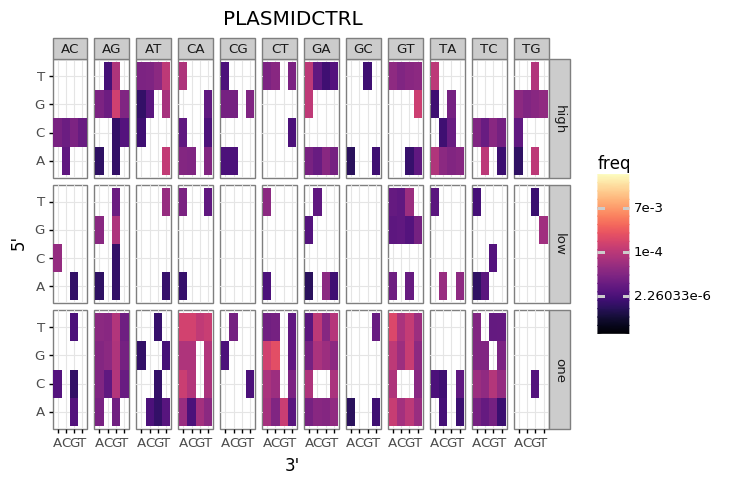

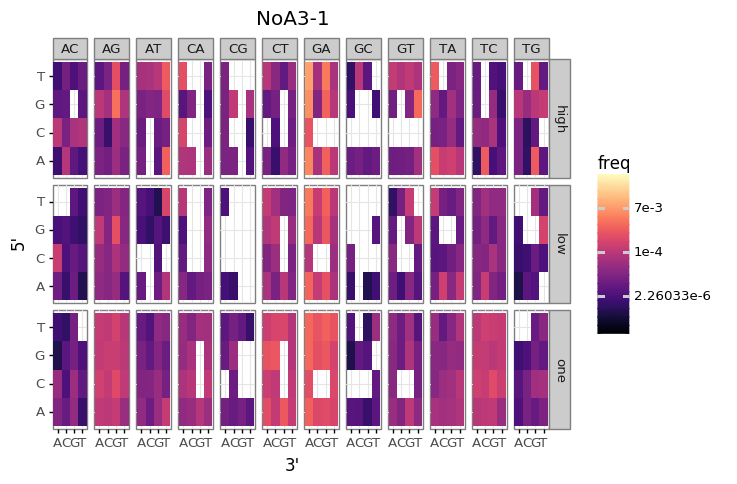

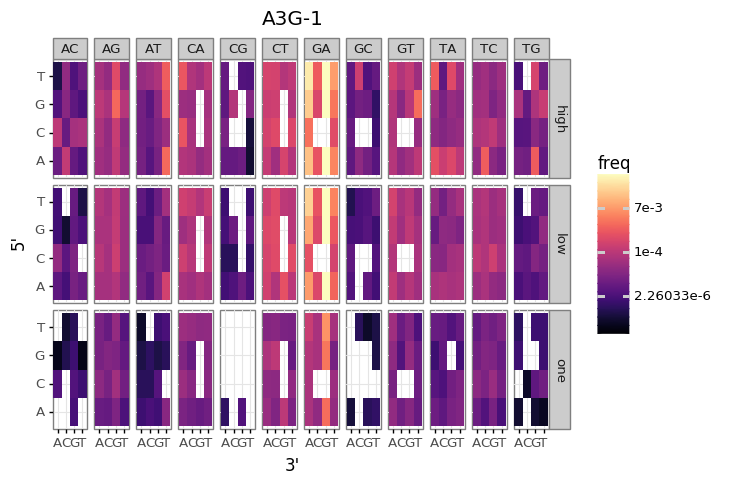

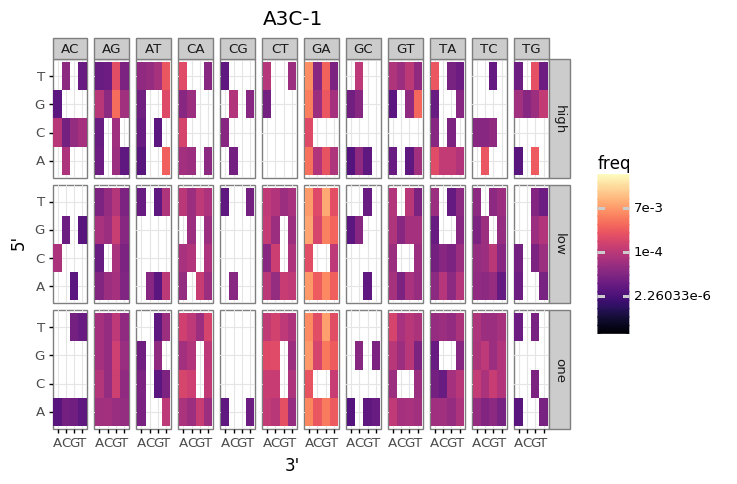

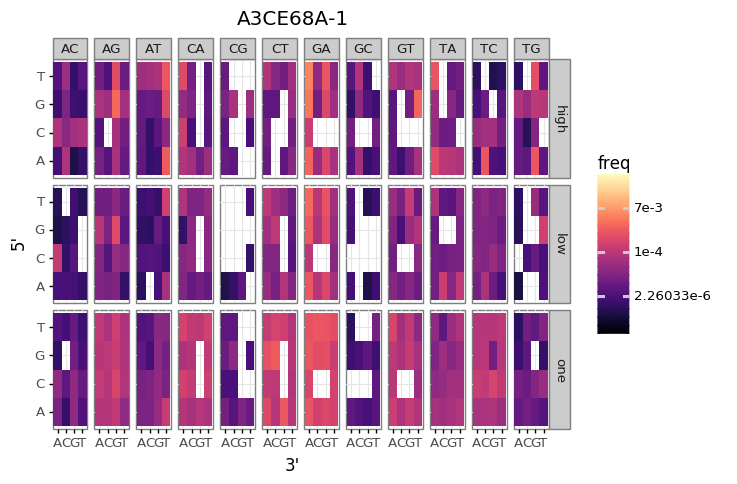

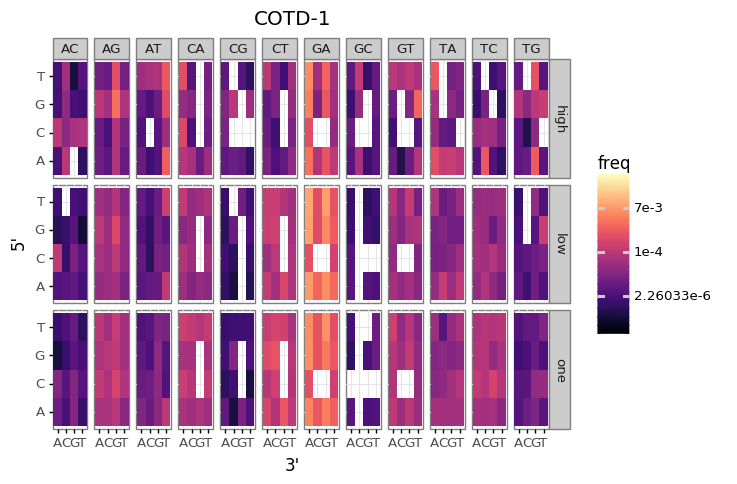

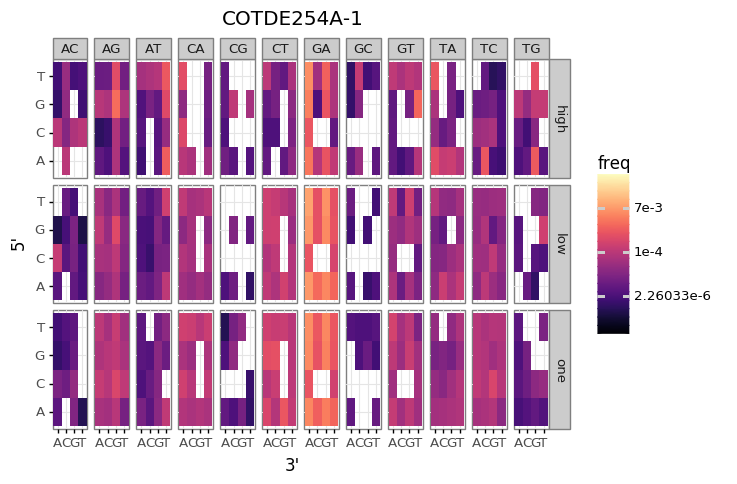

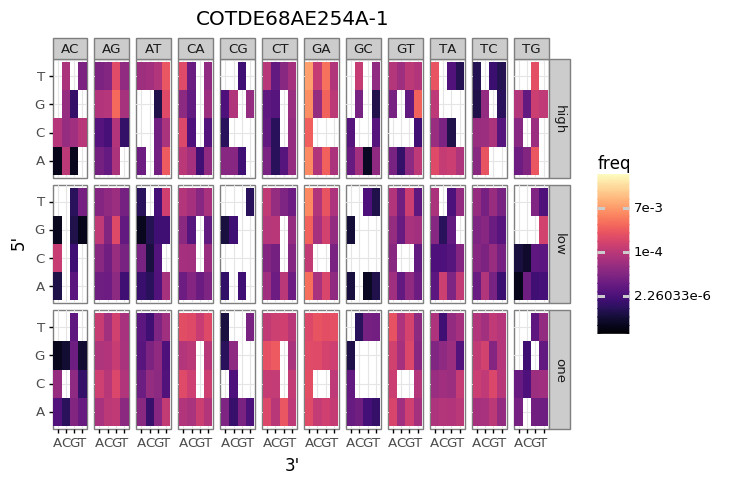

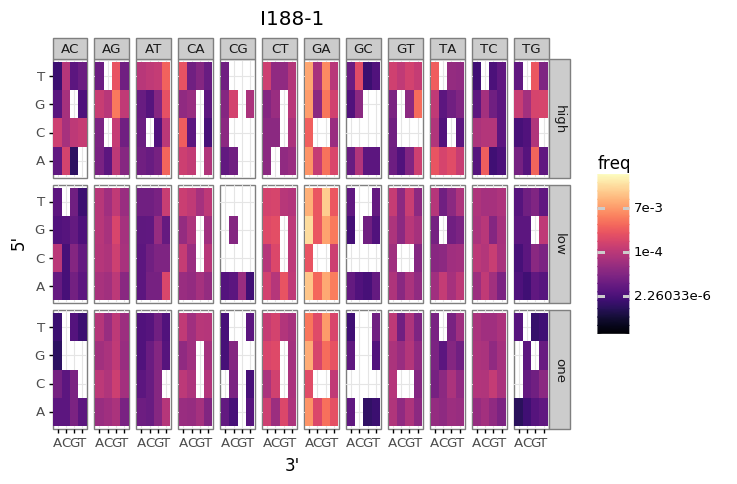

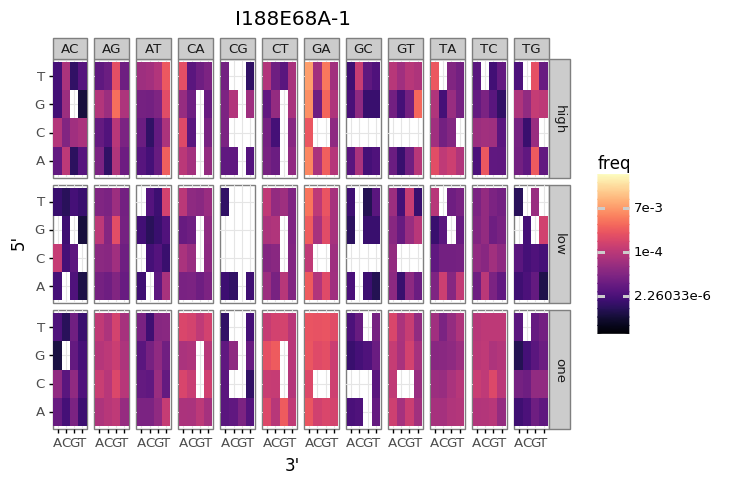

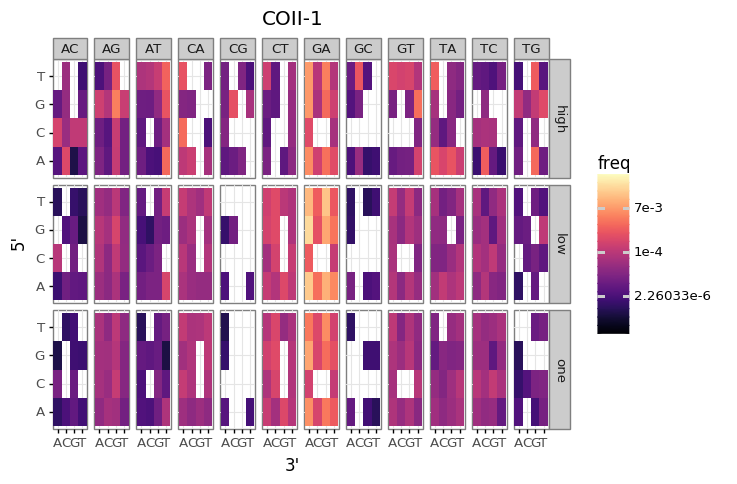

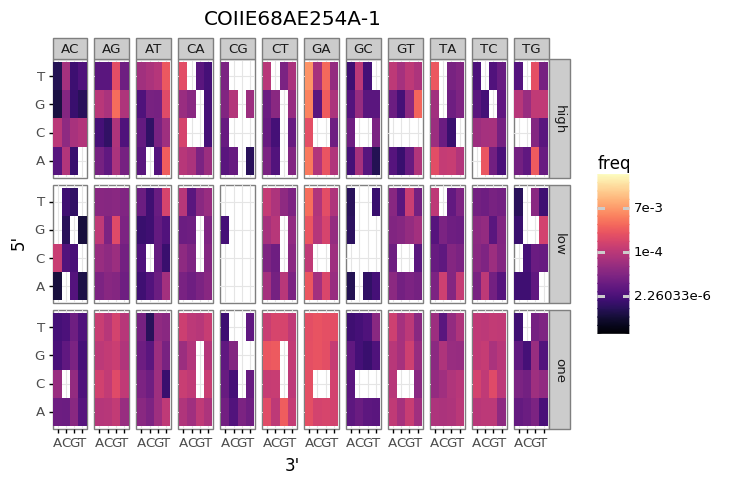

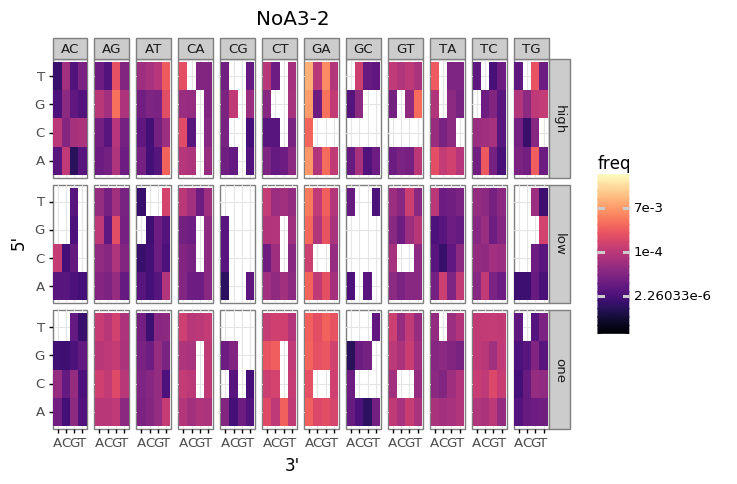

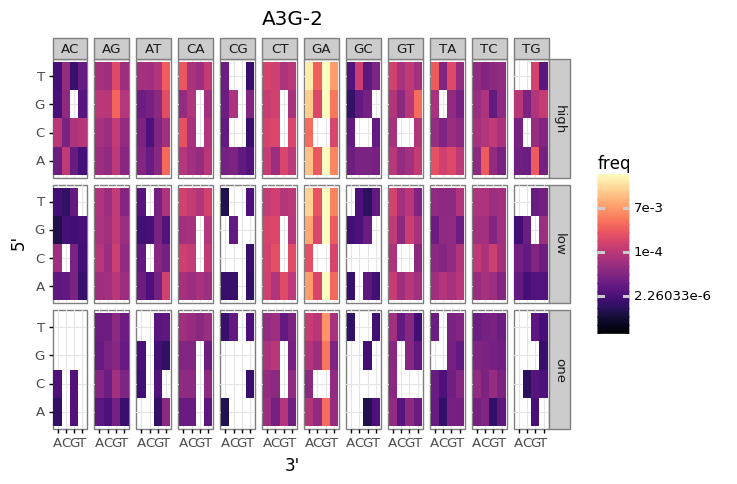

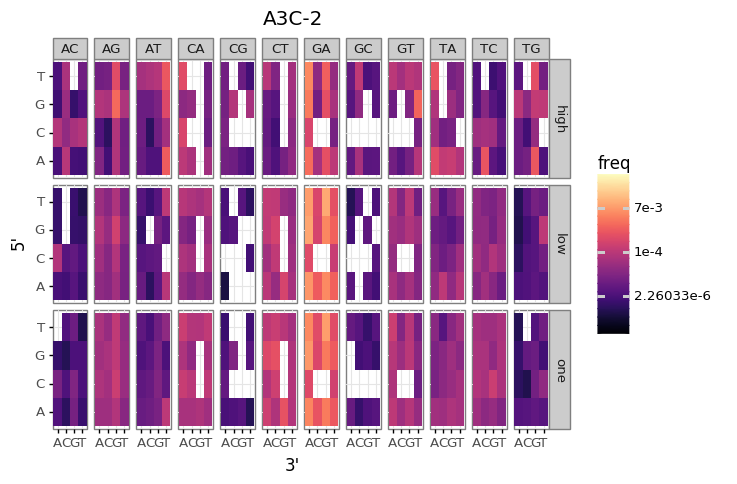

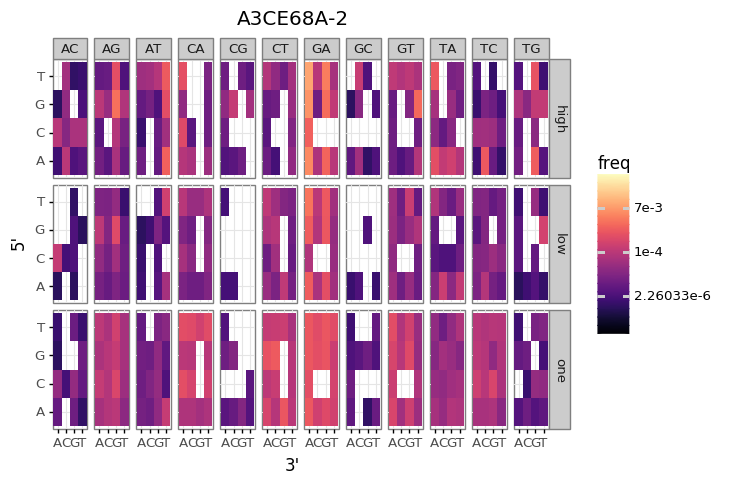

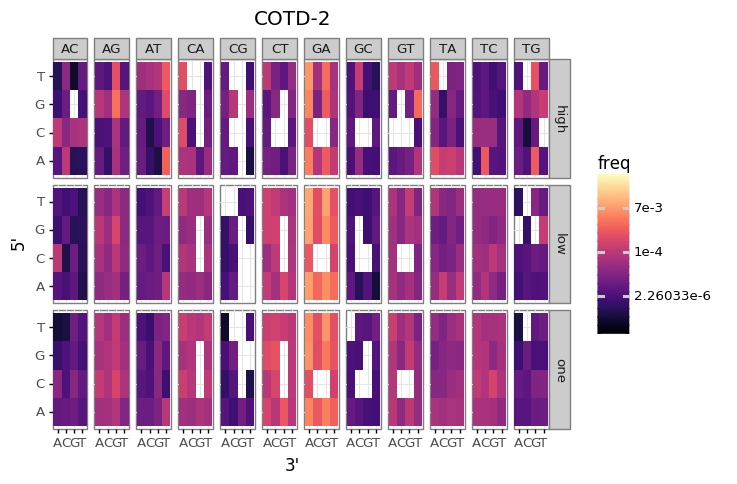

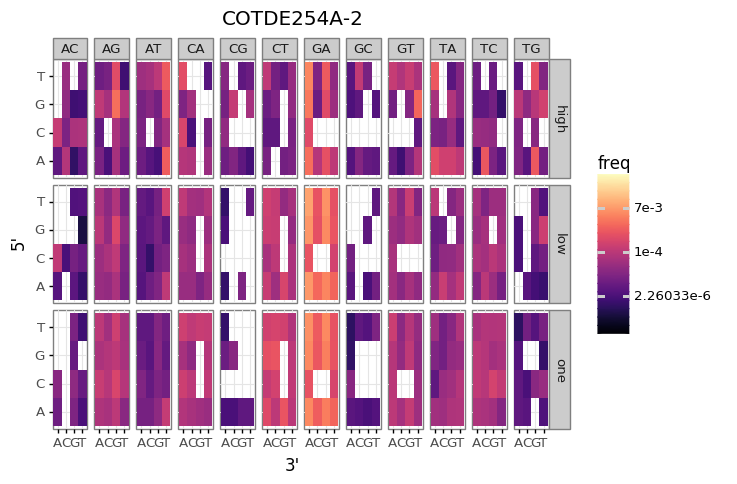

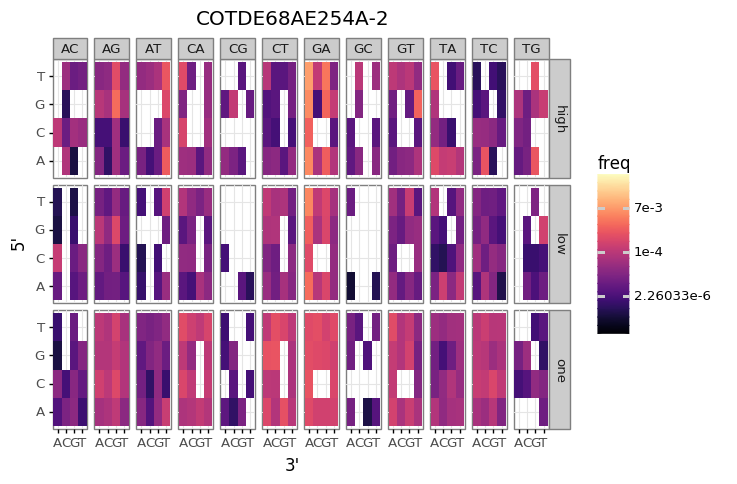

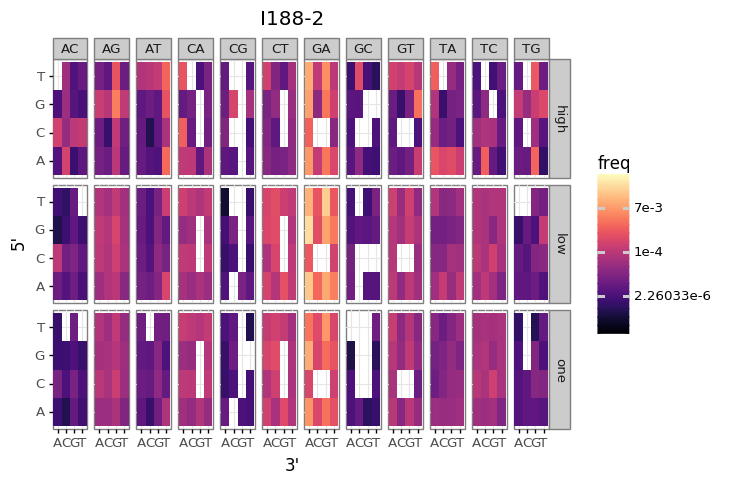

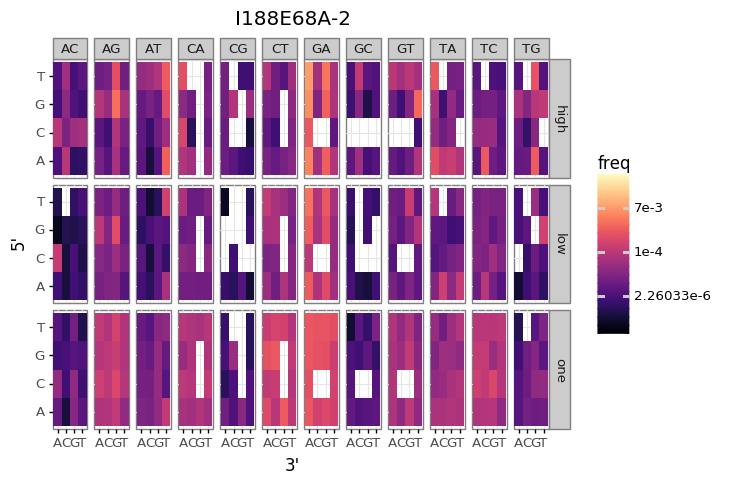

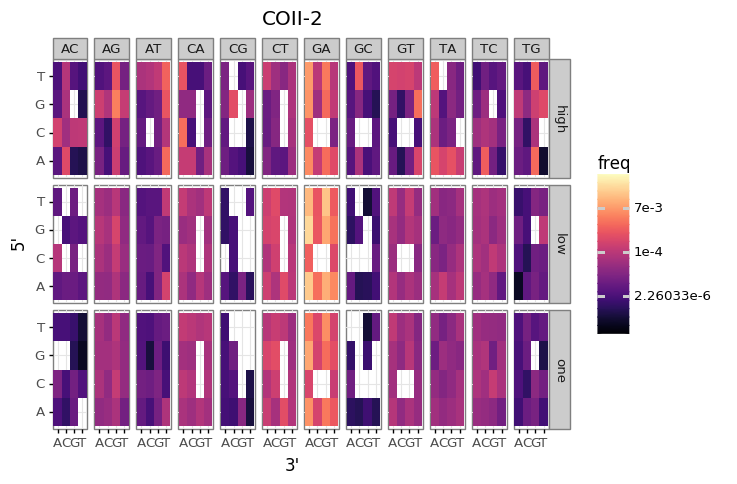

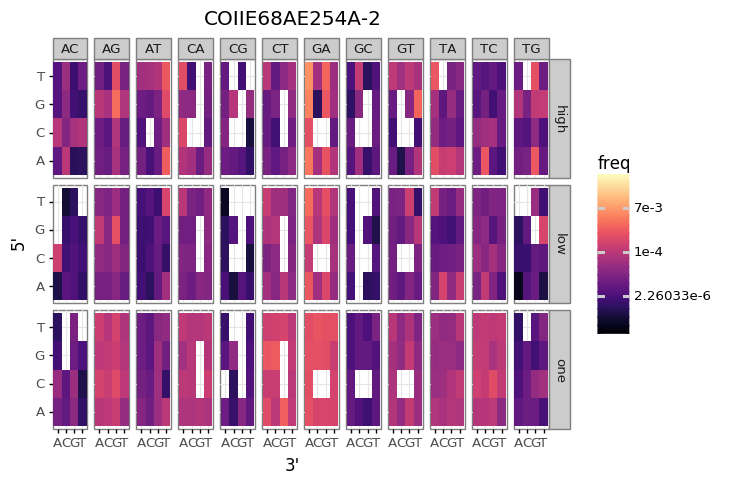

In [38]:
for sample in df_samplenames:
    print(sample)
    sample_df = mutinfo_dfs[sample]
    mcount_dict = motif_counts_dict[sample]
    one_sub = sample_df[sample_df['n_subs'] == 1]
    low_sub = sample_df[(sample_df['n_subs'] > 1) & 
                            (sample_df['n_subs'] <= 10)]
    high_sub = sample_df[sample_df['n_subs'] > 10]
    sample_subs_counts = pd.DataFrame(columns=['sub',"5'", "3'", 'motif', 'count', 'freq', 'sub_cat'])
    for sub_df, sub_cat in [(one_sub, 'one'), (low_sub, 'low'), (high_sub, 'high')]:
        sub_info_list = [sub_tup for sub_tups in sub_df['sub_tups'].to_list() for sub_tup in sub_tups]
        sub_info_df = pd.DataFrame(sub_info_list, columns=["5'", 'sub', "3'", "motif"])
        sub_info_df_counts = pd.DataFrame({'count' : sub_info_df.groupby( ["sub", "5'", "3'", "motif"] ).size()}).reset_index()
        sub_info_df_counts['sub_cat'] = [sub_cat]*len(sub_info_df_counts)
        sample_subs_counts = sample_subs_counts.append(sub_info_df_counts, ignore_index=True)
        sample_subs_counts['count'] = sample_subs_counts['count'].astype('int64')
    
    for i in range(len(sample_subs_counts)):
        m = sample_subs_counts.iloc[i]['motif']
        sample_subs_counts.at[i, 'freq'] = sample_subs_counts.iloc[i]['count'] / mcount_dict[m]
    sample_subs_counts['freq'] = sample_subs_counts['freq'].astype('float')
    display(sample_subs_counts.sort_values('freq', ascending=False).head())    
    heat_map = (ggplot(sample_subs_counts, aes("3'", "5'", fill='freq')) + 
                geom_tile() +
                scale_fill_cmap(name='magma', trans='log', limits=(1e-7, 1e-1)) +
                facet_grid(['sub_cat', 'sub'], labeller='label_value')+
                labs(title=f"{sample}")              
               )
    
    _heat_map = heat_map.draw()

## Parse bcinfo files into codon variant tables
I will use [dms_tools2.utils.barcodeInfoToCodonVariantTable](https://jbloomlab.github.io/dms_tools2/dms_tools2.utils.html#dms_tools2.utils.barcodeInfoToCodonVariantTable) to parse the /codoncounts/(sample)_bcinfo.txt.gz. files into codon variant tables. 


# New plan:
Alternatively, the /codoncounts/(sample)_bcinfo.txt.gz files (viewed at the end of this notebook) output by bcsubamp could be directly parsed using getSubstitions. 

In [24]:
trimmedrefseq = "CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAGGGGGGCAACTAAAGGAAGCTCTATTAGATACAGGAGCAGATGATACAGTATTAGAAGAAATGAGTTTGCCAGGAAGATGGAAACCAAAAATGATAGGGGGAATTGGAGGTTTTATCAAAGTAAGACAGTATGATCAGATACTCATAGAAATCTGTGGACATAAAGCTATAGGTACAGTATTAGTAGGACCTACACCTGTCAACATAATTGGAAGAAATCTGTTGACTCAGATTGGTTGCACTTTAAATTTTCCC"
samplenames2 = ["PLASMIDCTRL", "NoA3-1", "A3G-1", "A3C-1", "A3CE68A-1", "COTD-1", "COTDE254A-1", "COTDE68AE254A-1", "I188-1", "I188E68A-1", "COII-1", "COIIE68AE254A-1", "NoA3-2", "A3G-2", "A3C-2", "A3CE68A-2", "COTD-2", "COTDE254A-2", "COTDE68AE254A-2", "I188-2", "I188E68A-2", "COII-2", "COIIE68AE254A-2"]
samplebcinfofiles = []
for name in samplenames2:
    templist=[]
    templist.append("{0}/{1}".format(countsdir, name))
    samplebcinfofiles.append(templist)
bcinfo_dict = {}

# Create a zip object from two lists
zipbObj = zip(samplenames2, samplebcinfofiles)
 
# Create a dictionary from zip object
bcinfo_dict = dict(zipbObj)

bcinfo_dict

{'PLASMIDCTRL': ['./results_1and1b/codoncounts/PLASMIDCTRL'],
 'NoA3-1': ['./results_1and1b/codoncounts/NoA3-1'],
 'A3G-1': ['./results_1and1b/codoncounts/A3G-1'],
 'A3C-1': ['./results_1and1b/codoncounts/A3C-1'],
 'A3CE68A-1': ['./results_1and1b/codoncounts/A3CE68A-1'],
 'COTD-1': ['./results_1and1b/codoncounts/COTD-1'],
 'COTDE254A-1': ['./results_1and1b/codoncounts/COTDE254A-1'],
 'COTDE68AE254A-1': ['./results_1and1b/codoncounts/COTDE68AE254A-1'],
 'I188-1': ['./results_1and1b/codoncounts/I188-1'],
 'I188E68A-1': ['./results_1and1b/codoncounts/I188E68A-1'],
 'COII-1': ['./results_1and1b/codoncounts/COII-1'],
 'COIIE68AE254A-1': ['./results_1and1b/codoncounts/COIIE68AE254A-1'],
 'NoA3-2': ['./results_1and1b/codoncounts/NoA3-2'],
 'A3G-2': ['./results_1and1b/codoncounts/A3G-2'],
 'A3C-2': ['./results_1and1b/codoncounts/A3C-2'],
 'A3CE68A-2': ['./results_1and1b/codoncounts/A3CE68A-2'],
 'COTD-2': ['./results_1and1b/codoncounts/COTD-2'],
 'COTDE254A-2': ['./results_1and1b/codoncounts/C

In [25]:
#we must use a "wildtype" reference sequnce that is the same length as the sequencing?
#below is the sequence in "./data/Trimmed_Bru_Pol.fasta"
trimmedrefseq = "CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAGGGGGGCAACTAAAGGAAGCTCTATTAGATACAGGAGCAGATGATACAGTATTAGAAGAAATGAGTTTGCCAGGAAGATGGAAACCAAAAATGATAGGGGGAATTGGAGGTTTTATCAAAGTAAGACAGTATGATCAGATACTCATAGAAATCTGTGGACATAAAGCTATAGGTACAGTATTAGTAGGACCTACACCTGTCAACATAATTGGAAGAAATCTGTTGACTCAGATTGGTTGCACTTTAAATTTTCCC"
variants = barcodeInfoToCodonVariantTable(bcinfo_dict, trimmedrefseq)

KeyboardInterrupt: 

In [ ]:
#variants_nt = dms_variants.codonvarianttable()

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
plt.ion()

from IPython.display import display

from epistasis.pyplot import nonlinear



In [ ]:
p = variants.plotMutFreqs(variant_type='all', mut_type='codon', heightscale=1.9)
_ = p.draw()

In [ ]:
p = variants.plotNumMutsHistogram('codon', samples=None)
display(p)